# **Machine Learning Reconstruction of Surface Ocean pCO₂**
Spring 2025, EESC4243/STAT4243/5243 “Climate Prediction Challenges with Machine Learning”, Columbia University

## Introduction 
The ocean plays a crucial role in the global carbon cycle by absorbing atmospheric CO₂, having absorbed 38% of all anthropogenic fossil fuel emissions over the industrial era. 

Accurate estimation of air–sea CO₂ flux is critical for understanding the current and future global carbon budget, yet remains challenging due to the sparse and unevenly distributed nature of surface ocean pCO₂ observations. The **Surface Ocean CO₂ Atlas (SOCAT)** database (https://socat.info/) provides the most extensive dataset available, but its coverage is limited to only about 2% of all boxes of 1 degree X 1 degree (= 100km X 100km at the equator) over the last several decades. Data are particularly limited in high-latitude regions and during winter months.

To fill in the gaps in these data, statistical and machine learning (ML) techniques have been widely used to reconstruct global pCO₂ fields by interpolating between observations using environmental predictors such as sea surface temperature (SST), sea surface salinity (SSS), mixed layer depth (MLD), chlorophyll-a (Chl-a), and atmospheric CO₂ (xCO₂).

How good are these methods? Since the real full-coverage pCO2 of the ocean is unknown, we need another approach to assess the skill of ML-based reconstructions. Our answer is the **Large Ensemble Testbed (LET)**, which provides full-coverage pCO₂ output from Earth System Models, as well as associated driver varibles also from the ESM. In the context of this testbed, we can sample the pCO2 in the same pattern as real-world SOCAT and then reconstruct. Since the full-field pCO2 field is known ("Model Truth"), we can directly evaluate of ML reconstruction performance. With this approach, it has been shown that ML methods can capture seasonal variability well, they often overestimate decadal variability, particularly in regions with limited data coverage (Gloege et al. 2021).

This study builds upon previous work by incorporating a **pCO₂-Residual** approach to improve ML-based pCO₂ reconstructions. The **pCO₂-Residual** method removes the temperature-driven component from pCO₂ before applying ML, thereby reducing the dominance of temperature in predictions and enhancing the ability of the model to capture non-temperature-driven variability. 


We reproduce a portion of the analysis carried out by  
**Gloege et al. (2021)** *"Quantifying Errors in Observationally Based Estimates of Ocean Carbon Sink Variability."* **Global Biogeochemical Cycles** 34: e2020GB006788.  
([DOI: 10.1029/2020GB006788](https://doi.org/10.1029/2020GB006788))  

using the method of  
**Bennington et al. (2022)** *"Explicit Physical Knowledge in Machine Learning for Ocean Carbon Flux Reconstruction: The pCO2-Residual Method"*. **Journal of Advances in Modeling Earth Systems**, 14(10). ([DOI: 10.1029/2021ms002960](https://doi.org/10.1029/2021ms002960))

Our study:
1. Implements an **XGBoost-based pCO₂-Residual reconstruction**  (Bennington et al. 2022).
2. Evaluates reconstruction performance using a Large Ensemble Testbed, with **bias and correlation metrics** as in Gloege et al (2021).


### Running Notes
1. Users need to enter their GitHub/LEAP-Pangeo username at the end of Section 2.
2. Several time-consuming steps have outputs saved to files, so they only need to be run initially or if changes are made:  
    - Section 4.3: ML Training (~1 minute/ESM member)  
    - Section 4.4: Reconstruction/Inference (~1 minute/ESM member)  
    - Section 4.4.1: Summation of pCO2-Residual and pCO2-T to recover pCO2 (~15 seconds/ESM member)


    With a **128GB CPU**, actual runtimes may vary based on system load and selected members, but this serves as a general guideline.


## Important Controls:  
- **your_username**: The username of the person running the code.  
- **owner_username**: The username of the notebook owner.  
- **runthiscell**: Default = 1.  
  - **Disable a cell by setting `runthiscell=0`**.  
  - **Reviewers should set `runthiscell=-1` to save time and space**.  

### Instructions:  
- **If you're running your own code**:  
  - 'your_username' should be the same as 'owner_username' (both should be your account name).  
  - Disable a cell by setting 'runthiscell=0'.  

- **If you're a reviewer**:  
  - Set `your_username` to your own name while keeping `owner_username` as the notebook owner's name.  
  - Set `runthiscell=-1`.  
  - Run only the first member of the first ESM and load ML results for the other members from the owner's saved bucket file.

In [1]:
your_username = 'mc5601'  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = ''  # Reviewer should not change this name

## Overview of the Large Ensemble Testbed Approach

This figure (Figure 1 of Gloege et al. 2021) illustrates the main steps in the pCO₂ reconstruction workflow using the Large Ensemble Testbed. 
Panel A shows the sampling, training, and reconstruction process, while panel B breaks down the reconstructed 
CO₂ flux into different temporal components for evaluation. 

In this project, we take a similar approach, but we remove the complication of the calculation of CO₂ flux from pCO₂. Results can be expected to be qualitatively the same. 


In [2]:
from IPython.display import Image
Image(filename="LEAPCourse-Climate-Pred-Challenges/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project3-ReconstructPCO2/images/figure1.png", width=1000)

FileNotFoundError: [Errno 2] No such file or directory: 'LEAPCourse-Climate-Pred-Challenges/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project3-ReconstructPCO2/images/figure1.png'

# 0. Setup Workspace and Import Packages
We use %%capture to suppress output and keep the notebook clean. However, feel free to remove it if you want to check warnings or logs.


In [3]:
%%capture
!pip install tensorflow
!pip install keras

In [4]:
import os
os.getcwd()


'/home/jovyan/LEAPCourse-Climate-Pred-Challenges/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project3-ReconstructPCO2/notebooks'

In [5]:
import os
os.chdir('Project-StarterCodes/Project3-ReconstructPCO2/notebooks/')


FileNotFoundError: [Errno 2] No such file or directory: 'Project-StarterCodes/Project3-ReconstructPCO2/notebooks/'

In [ ]:
!pwd

In [7]:
%%capture
### standard imports ###
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import fsspec
### Python file with supporting functions ###
# standard imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
# Redirect all low-level stderr output
sys.stderr = open(os.devnull, 'w')

import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',100)
import csv
import cmocean as cm

# machine learning libraries
import xgboost as xgb     
from xgboost import XGBRegressor

# Change to the parent directory of the current working directory. (Run only once—otherwise it will keep moving up the directory tree)
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Python file with supporting functions
import lib.residual_utils as supporting_functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial


E0000 00:00:1745936958.795312    1894 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745936958.802067    1894 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745936958.822169    1894 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745936958.822188    1894 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745936958.822191    1894 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745936958.822193    1894 computation_placer.cc:177] computation placer already registered. Please check linka

In [8]:
### Setting the date range to unify the date type ###

# Define date range
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'

# create date vector, adds 14 days to start & end
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS')


init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

# 1. Surface ocean pCO2: A sparse data challenge

Here, we visualize all SOCAT data for the period selected for this analysis (default is 2004-2023). 

We plot the total number of months of available data at each 1 degree X 1 degree location (100x100km at the equator). 

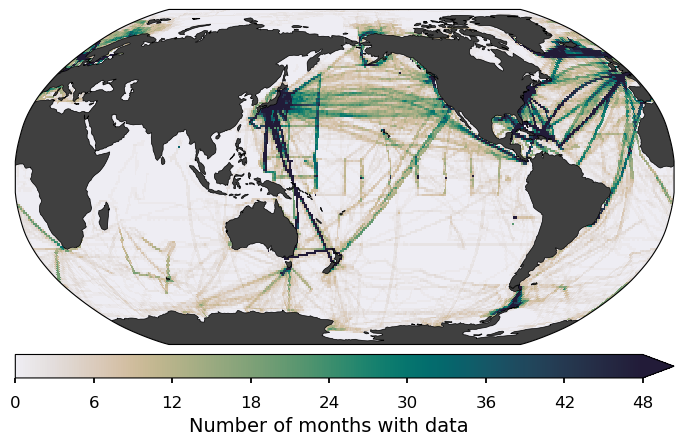

In [9]:
# 1. Surface ocean pCO2: A sparse data challenge
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"
# Updated loading approach
socat_mask_data =  xr.open_zarr(socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))

non_zero_counts = (socat_mask_data.socat_mask != 0).sum(dim="time")
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                   cbar_mode='each',
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[1,1])
    
    vrange = [0, 48, 6]
    cmap = cm.cm.rain
    data = xr_add_cyclic_point(non_zero_counts, cyclic_coord='xlon')
    data = data.assign_coords(xlon=(((data.xlon + 180) % 360) ))
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                      vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0,extend='max')
    worldmap.set_cbar_xlabel(col, 'Number of months with data', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

SOCAT data coverage is uneven, with some regions, particularly in the Southern Hemisphere and open ocean areas, having significantly fewer observations. Regions with denser observational coverage, such as the Northern Hemisphere, tend to have lower biases in CO2 flux reconstructions compared to sparsely sampled areas like the Southern Ocean.

# 2. Data Introduction and Storage

## **2.1 Input (Features) Sources**
The **input features** for the machine learning model are derived from **pre-processed Earth System Model (ESM) outputs or inputs**

### **Feature and Target Variables for the ML Model**
The features used for training the **pCO₂-Residual machine learning model** are listed below:


| **Feature** | **Description** | **ESM Input or Output?** | 
|------------|----------------|----------------|
| **SST (Sea Surface Temperature)** | Simulated ocean surface temperature | **ESM Output** |  
| **SST_anom** | SST anomaly from climatology | **ESM Output** |  
| **SSS (Sea Surface Salinity)** | Simulated surface ocean salinity | **ESM Output** |  
| **SSS_anom** | SSS anomaly from climatology | **ESM Output** |  
| **MLD_clim_log** | Log-transformed climatological mixed layer depth | **ESM Output** |  
| **Chl-a (Chlorophyll concentration)** | Proxy for biological activity (log-transformed) | **ESM Output** |  
| **Chl-a_anom** | Anomaly of Chl-a | **ESM Output** |  
| **xCO₂ (Atmospheric CO₂ concentration)** | Atmospheric CO₂ mole fraction | **ESM Input, from data** |  
| **A, B, C** | Space on the globe | **See Bennington et al. 2022, Table 1** |  
| **T0, T1** | Time | **See Bennington et al. 2022, Table 1** |  


The **target variable** for reconstruction is:
- **pCO₂-Residual**: This deviation from the temperature-driven component of pCO₂, reducing SST's dominance in ML reconstructions and improving model performance in data-sparse regions (detailed below).

### **Data Sources and Paths**
The data is stored in a **cloud environment, LEAP-Pangeo**, ensuring efficient access and scalability for the machine learning workflow. Key datasets include:

- **Ensemble dir**:

  Contains the original data from pre-processed Earth System Model (ESM) outputs, available for 100+ ESM members. For computational efficiency, we rely on a selection of this dataset compiled by TA Xinyi Ke. The full ensemble data is available and could be explored, with due consideration of storage constraints. 
  
- **ML Input and Target Data**:

    Provides a dataframe-format dataset containing preprocessed ML inputs and ground truth from a selected subset of ensemble members. You may also generate your own dataset for a custom selection or range of members (see reference: Project3_Data.ipynb). Due to limited GCS storage, we recommend using the provided dataset for most projects.
  
- **SOCAT Data (Mask File)**:  

  Masking file based on real-world **SOCAT pCO₂ observations**. Here, these data are not used directly, but are input solely so that their sampling pattern in space and time can be applied to model pCO2 fields, thus mimicing real-world observational density.

### **Key Considerations:**
- **pCO₂-Residual**: By removing the temperature-driven component from pCO₂, we enhance the ability of machine learning models to capture **non-temperature-driven variability**, particularly in poorly observed regions.
- **Data Subsampling Based on SOCAT**: The use of a **SOCAT-derived mask** ensures that the ML model is trained and evaluated using a realistic observational distribution, mitigating potential biases from uneven data coverage.

### **Final Input Structure**:
- **Feature Matrix**: `(N, 12)`, where `N` represents the number of samples, and 12 predictor variables are used.
- **Target Variable**: `pCO₂-Residual`, which the model aims to reconstruct.


In [102]:
# features for ML:
features_sel = ['sst','sst_anom','sss','sss_anom','mld_clim_log','chl_log','chl_log_anom','xco2','A', 'B', 'C', 'T0', 'T1']

# the target variable we reconstruct:
target_sel = ['pco2_residual'] # this represents pCO2 - pCO2-T (calculated in notebook 00)

 **Compute the temperature-driven component** of pCO₂:

$$
\text{pCO}_{2,T} = \overline{\text{pCO}_2} \cdot \exp\left[ 0.0423 \cdot (T - \overline{T}) \right]
$$

- $ \overline{\text{pCO}_2} $: long-term mean of surface ocean pCO₂  
- $ T $: sea surface temperature at a given time/location  
- $ \overline{T} $: long-term mean sea surface temperature  
- $ 0.0423 $: empirically derived constant (from Takahashi et al., 1993)


 **Subtract to get the residual**:

$$
\text{pCO}_{2,\text{Residual}} = \text{pCO}_2 - \text{pCO}_{2,T}
$$

This residual is then used as the **target variable** in ML training, helping disentangle the direct solubility-driven temperature effect from other biogeochemical processes.

In our workflow, this calculation was done during processing of the Earth System Model (ESM) dataset, not included in this notebook. The datasets under `ensemble_dir` include the variable `pCO2_T`. For this notebook, we will directly use the preprocessed ML input dataset, which includes `pco2_residual`.

Later in the notebook, we recover the total pCO2 by **adding the temperature component back** to the residual:

$$
\text{pCO}_2 = \text{pCO}_{2,\text{Residual}} + \text{pCO}_{2,T}
$$


In [103]:
### set up for getting files from leap bucket ###
fs = gcsfs.GCSFileSystem()

### paths for loading: ###
# directory of regridded members from notebook 00
ensemble_dir = "gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members" # path to regridded data
path_seeds = "gs://leap-persistent/abbysh/pickles/random_seeds.npy" # random seeds for ML

# directory of reference zarr files
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'

# socat data file
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"

# preprocessed ESM ensemble members
MLinputs_path = "gs://leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs_parquet"



### **Output Data Storage and Model Saving**

The output data generated by this notebook, including model predictions, performance metrics, and trained models, is saved in a cloud-based environment using a user-specific directory structure. This ensures that each user’s results are organized and accessible without interfering with others’ work.

The output data is organized into three main categories:  
1. **Machine Learning Models:** Trained models are saved for future use, ensuring that results can be replicated without re-training.  
2. **Reconstructions:** Predicted pCO₂ fields are stored for further analysis and visualization.  
3. **Performance Metrics:** CSV files containing test and unseen data performance metrics are saved for easy evaluation.


### Users must enter their Github/LEAP-Pangeo username in the cell below

In [104]:
grid_search_approach = 'nmse'
output_dir = f'gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/{grid_search_approach}/post02_xgb' # where to save machine learning results

model_output_dir = f"{output_dir}/trained" # where to save ML models
recon_output_dir = f"{output_dir}/reconstructions" # where to save ML reconstructions

metrics_output_dir = f'{output_dir}/metrics' # where to save performance metrics
test_perform_fname = f"{metrics_output_dir}/xgb_test_performance_{init_date}-{fin_date}.csv" # path for test performance metrics
unseen_perform_fname = f"{metrics_output_dir}/xgb_unseen_performance_{init_date}-{fin_date}.csv" # path for unseen performance metrics

xgb_model_save_dir = f'{output_dir}/saved_models_{init_date}-{fin_date}' # where to save .json model file
xgb_model_local_save_dir = "output/model_saved"


# 3.  Earth System Models and their Ensemble Members
This notebook utilizes data from multiple Earth System Models (ESMs) that are part of the **Large Ensemble Testbed (LET)**. The LET originally includes **100 ensemble members** from different ESM, each representing unique initial conditions. These ensemble members are crucial for capturing internal climate variability and assessing model uncertainty.  

However, to optimize computational efficiency and simplify machine learning workflows, we select some representative member from the three ESM. If desired, you can modify the `mems_dict` variable to include more members from each ESM. This flexibility allows for expanded analyses while maintaining the structure of this notebook.


In [105]:
mems_dict = dict()

# Get all paths
all_paths = fs.ls(MLinputs_path)

for ens_path in all_paths:             
    ens = ens_path.split('/')[-1]
    mems = fs.ls(ens_path)
    for mem in mems:        
        memo = mem.split('/')[-1]
        if ens not in mems_dict:
            mems_dict[ens] = [memo]
        elif ens in mems_dict:
            mems_dict[ens].append(memo)


In [106]:
mems_dict

{'ACCESS-ESM1-5': ['member_r10i1p1f1',
  'member_r1i1p1f1',
  'member_r2i1p1f1',
  'member_r31i1p1f1',
  'member_r5i1p1f1'],
 'CanESM5': ['member_r1i1p1f1',
  'member_r1i1p2f1',
  'member_r2i1p1f1',
  'member_r3i1p2f1',
  'member_r6i1p2f1'],
 'MPI-ESM1-2-LR': ['member_r11i1p1f1',
  'member_r12i1p1f1',
  'member_r15i1p1f1',
  'member_r22i1p1f1',
  'member_r23i1p1f1'],
 'UKESM1-0-LL': ['member_r1i1p1f2',
  'member_r2i1p1f2',
  'member_r3i1p1f2',
  'member_r4i1p1f2',
  'member_r8i1p1f2']}


**Note:**  
The `ensemble_dir` contains a large collection of ESM outputs. We’ve already preprocessed data for **four ESMs**, each with **five members**, and saved them in the `MLinputs_path` directory for convenience.

In the starter notebook, we select only **3 ESMs** and **3 members per model** (see next cell) to reduce storage and computation. If you'd like to explore additional models or members, we recommend starting with the remaining preprocessed data available under `MLinputs_path`.

If you wish to go further and access additional members or ESMs from `ensemble_dir`, please refer to `Project3_Data.ipynb` for instructions on how to retrieve and preprocess the raw data into ML-ready DataFrames.

---
> **Storage:** Each student has a 25GB storage limit in your home directory. Please avoid stay within the quota. Each preprocessed DataFrame (covering data from 2004-01-01 to 2023-12-31) is approximately **2.35 GB**. Intermediate files are also needed.

> **/leap-persistent:** Instead of relying on home directories, we use the shared /leap-persistent/ bucket, which is a larger shared resource with common access permissions. Though there is not a quoata, please be a good citizen and avoid keeping lots of files you do not need. See the notebook "files_leappersistent_management.ipynb" with code needed to manage your files. 

> **Sharing from /leap-persistent:**  Groups can share files seamlessly with the /leap-persistent/ bucket. Consider this approach for your group. 

---

In [107]:
## Here you can change which models and how many members you use
random.seed(42)  # Set seed for reproducibility

selected_ensembles = ['ACCESS-ESM1-5', 'CanESM5', 'MPI-ESM1-2-LR']
selected_members_dict = {esm: mems_dict[esm] for esm in selected_ensembles}

selected_mems_dict = {}
num_members = 3  # Set the number of ensemble members from each ESM

for ens, members in selected_members_dict.items():
    if len(members) >= num_members:
        selected_mems_dict[ens] = random.sample(members, num_members)  # Select `num_members` random members
    else:
        selected_mems_dict[ens] = members  # If there are fewer members than `num_members`, select all

print(selected_mems_dict)

{'ACCESS-ESM1-5': ['member_r10i1p1f1', 'member_r5i1p1f1', 'member_r2i1p1f1'], 'CanESM5': ['member_r2i1p1f1', 'member_r1i1p2f1', 'member_r1i1p1f1'], 'MPI-ESM1-2-LR': ['member_r12i1p1f1', 'member_r11i1p1f1', 'member_r15i1p1f1']}


To better understand how the data is organized in GCS, we can use the following command to list all files under a specific path. In this example, we check the dataset for the ESM 'ACCESS-ESM1-5' and its first member (index 0):

In [108]:
fs = gcsfs.GCSFileSystem()
ens0 = 'ACCESS-ESM1-5'
member_dir = f"{ensemble_dir}/{ens0}/{selected_mems_dict[ens0][0]}"
files = fs.ls(member_dir)

print("Files in GCS directory:")
for file in files:
    print(file)


Files in GCS directory:
leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/chlclim_ACCESS-ESM1-5.r10i1p1f1.Omon.zarr


Similarly, to loop through all selected ESMs and their members, we can use the following code. This allows us to check the directory and filename for each ensemble-member combination:

In [109]:
for ens, mem_list in selected_mems_dict.items():
    for member in mem_list:
        print(ens, member)
        data_dir = f"{MLinputs_path}/{ens}/{member}"
        files = fs.ls(data_dir)
        for file in files:
            print(file)

ACCESS-ESM1-5 member_r10i1p1f1
leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs_parquet/ACCESS-ESM1-5/member_r10i1p1f1/MLinput_ACCESS-ESM1-5_r10i1p1f1_mon_1x1_200401_202312.parquet
ACCESS-ESM1-5 member_r5i1p1f1
leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs_parquet/ACCESS-ESM1-5/member_r5i1p1f1/MLinput_ACCESS-ESM1-5_r5i1p1f1_mon_1x1_200401_202312.parquet
ACCESS-ESM1-5 member_r2i1p1f1
leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs_parquet/ACCESS-ESM1-5/member_r2i1p1f1/MLinput_ACCESS-ESM1-5_r2i1p1f1_mon_1x1_200401_202312.parquet
CanESM5 member_r2i1p1f1
leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs_parquet/CanESM5/member_r2i1p1f1/MLinput_CanESM5_r2i1p1f1_mon_1x1_200401_202312.parquet
CanESM5 member_r1i1p2f1
leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs_parquet/CanESM5/member_r1i1p2f1/MLinput_CanESM5_r1i1p2f1_mon_1x1_200401_202312.parquet
CanESM5 member_r1i1p1f1
leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs_parquet/CanESM5/member_r1i1p1f1/ML

Unlike the sparse observational data, Earth System Model (ESM) outputs provide continuous global coverage of climate variables. To better understand the observational constraints, we apply a SOCAT-based mask to the ESM data. This mask mimics the data sparsity of real-world observations by selectively masking regions where SOCAT observations are absent. The SOCAT mask varies over time, reflecting the temporal evolution of observational coverage.

Using this mask, we process all ESM data to generate a sparse dataset that requires reconstruction, where the unmasked regions serve as the ground truth for evaluating reconstruction accuracy.

In this figure, we visualize the pCO₂ field from a selected ensemble member of an ESM for a specific time period, applying the SOCAT mask to illustrate how the data coverage changes.

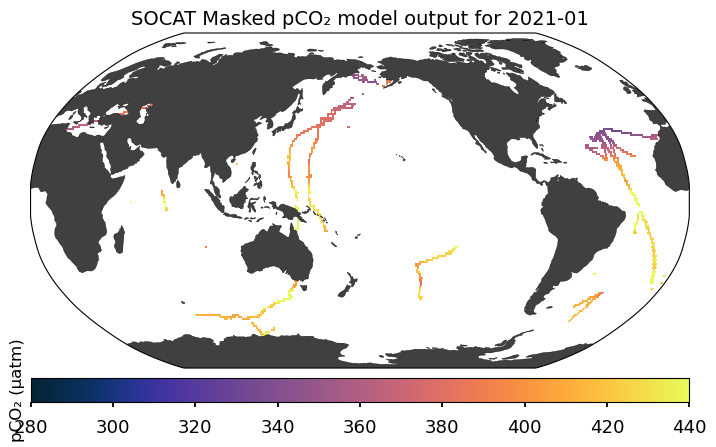

In [110]:
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]

member_dir = f"{ensemble_dir}/{first_ens}/{first_mem}"
member_path = fs.glob(f"{member_dir}/*.zarr")[0]
# member_data = xr.open_mfdataset('gs://'+member_path, engine='zarr').sel(time=slice(str(dates[0]),str(dates[-1])))
member_data = xr.open_zarr('gs://'+member_path).sel(time=slice(str(dates[0]),str(dates[-1])))

plot_style = "seaborn-v0_8-talk"

cmap = cm.cm.thermal
cbar_title = 'pCO₂ (µatm)'
vrange = [280, 440]  # Ensure correct range format

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) 
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='each',
                           colorbar=True,  # Enable colorbar
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    
    chosen_time = '2021-01'
    data = member_data["spco2"].sel(time=chosen_time).squeeze()
    data = xr_add_cyclic_point(data, cyclic_coord='xlon')    
    mask = socat_mask_data.sel(time=chosen_time)["socat_mask"].squeeze()
    mask = xr_add_cyclic_point(mask, cyclic_coord='xlon')    
    masked_data = np.ma.masked_array(data, mask=(mask == 0))  # Mask where mask==0

    data = data.assign_coords(xlon=(((data.xlon + 180) % 360) - 180))
    mask = mask.assign_coords(xlon=(((mask.xlon + 180) % 360) - 180))

    sub = worldmap.add_plot(lon=data['xlon'], 
                            lat=data['ylat'], 
                            data=masked_data,
                            vrange=vrange,  # Corrected vrange
                            cmap=cmap, 
                            ax=0)

    # Add colorbar properly
    colorbar = worldmap.add_colorbar(sub, ax=0)
    worldmap.set_cbar_ylabel(colorbar, cbar_title, fontsize=12)

    # Add title
    worldmap.set_title("SOCAT Masked pCO₂ model output for 2021-01", ax=0, fontsize=14)

    plt.show()


We can adjust the values of chosen_time and mmeber to explore different available data, which helps us better understand the masked ESM data that will be used in the following machine learning work.

# 4. ML Reconstruction

## 4.1 Data Split

We split data to training data set and testing dataset based on date.

In [92]:
### train-validate-test split proportions ###

select_dates = []
test_dates = []

for i in range(0,len(dates)):
    if i % 5 != 0:
        select_dates.append(dates[i]) ### 80% train days set ###
    if i % 5 == 0:
        test_dates.append(dates[i]) ### 20% test days set ### 

### Then, the month numbers above are converted back to their respective datetime objects.

year_mon = []

for i in range(0,len(select_dates)):
    
    tmp = select_dates[i]
    year_mon.append(f"{tmp.year}-{tmp.month}")
    
test_year_mon = []

for i in range(0,len(test_dates)):
    
    tmp = test_dates[i]
    test_year_mon.append(f"{tmp.year}-{tmp.month}")

## 4.2 Hyperparameters

In [93]:
params = {
    'n_estimators': 500,  # Number of boosting rounds
    'max_depth': 6,  # Maximum depth of each tree to control model complexity
    'learning_rate': 0.05,  # Step size shrinkage to prevent overfitting
    'subsample': 0.8,  # Fraction of samples used for training each tree
    'colsample_bytree': 0.8,  # Fraction of features used per tree
    'gamma': 0.1,  # Minimum loss reduction required for further partitioning
    'min_child_weight': 5,  # Minimum sum of instance weight in a leaf node
    'reg_alpha': 0.1,  # L1 regularization to reduce model complexity
    'reg_lambda': 1.0,  # L2 regularization for preventing overfitting
    'objective': 'reg:squarederror',  # Loss function for regression tasks
    'n_jobs': 30,  # Number of parallel threads to use for training
    'eval_metric': 'rmse',
    'early_stopping_rounds': 50  # Stop training if performance doesn't improve for 50 rounds
}

### Important Note: Run ML (4.3) and Reconstruction (4.4) Part Only Once

The **ML Reconstruction** step needs to be run **only once** for each ML model developed. This helps save computational resources and execution time.

The reconstruction data is saved under our **own username-specific workspace** in GCS. This means that even if you exit and re-enter JupyterHub, your data will remain available, eliminating the need for reprocessing.

### Before Running Again:
Before re-running the ML training steps, make sure a new experiment is actually necessary. Avoiding redundant computations helps optimize time and resource usage. It's also a good idea to monitor your storage regularly and clean up unnecessary files. If you're certain that no new experiment is needed, you can comment out the relevant code (set runthiscell = "0") to prevent accidental re-execution.

For reviewer, set runthiscell to -1.

## ML train/val/test data
The ML model was trained on **masked synthetic data** that mimics real-world observational sampling patterns (SOCAT). Specifically, for each ensemble member, we:

1. **Filtered valid samples** by selecting grid cells that have:
   - No missing values in input features or the target (`pCO₂-Residual`),
   - Physically realistic `pCO₂-Residual` values (between -250 and 250 μatm),
   - An ocean mask indicating valid ocean regions.

2. **Identified SOCAT-like samples** using a binary `socat_mask`.  
   - We defined the **training pool** as grid cells where **`socat_mask == 1`**, and the time falls within a list of pre-selected training months (`year_mon`).
   - Similarly, **testing data** was drawn from SOCAT-like samples falling into the `test_year_mon` time range.

3. **Performed a secondary train/val split** (within the training pool) using a stratified random seed matrix (`random_seeds`), where the seed location is tied to each ensemble member to ensure reproducibility and model diversity across members.

4. The **“unseen” data**, i.e., where **`socat_mask == 0`** but data is otherwise valid, was reserved for reconstruction evaluation in non-observed regions.

This ensures that:
- Training and testing sets do **not overlap in time** (`year_mon` vs. `test_year_mon`),
- And are drawn from the same spatial sampling mask, preserving the real-world SOCAT sampling pattern.



## 4.3 ML Training

To avoid re-run the ML training, set runthiscell = 0 

In [94]:
runthiscell = 1  # 0 will turn off, 1 will turn on, -1 will only run the first member. Reviewers should set this to -1.

if runthiscell: 
    random_seeds = np.load(fs.open(path_seeds))   
    
    seed_loc_dict = defaultdict(dict)
    for ens,mem_list in mems_dict.items():
        sub_dictt = dict()
        for no,mem in enumerate(mem_list):
            sub_dictt.update({mem:no})
        seed_loc_dict.update({ens:sub_dictt})
    
    val_prop = .2 # 20% of training data for validation
    test_prop = .0 # Since we apply this split to X_train, we set it to zero. We have X_test as testing dataset.
    
    print(datetime.datetime.now())

    if runthiscell == -1:
        print("Reviewing process: Running ML only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
        first_mem = selected_mems_dict[first_ens][0]   # Get the first member in that ensemble
        run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dictionary with only the first ensemble and member
    else:
        run_selected_mems_dict = selected_mems_dict
    
    for ens, mem_list in run_selected_mems_dict.items():
        for member in mem_list:
            print(ens, member)
            seed_loc = seed_loc_dict[ens][member]
            data_dir = f"{MLinputs_path}/{ens}/{member}"
            fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.parquet"
            file_path = f"{data_dir}/{fname}"
    
            with fs.open(file_path, 'rb') as filee:
                df = pd.read_parquet(filee)
                df['year'] = df.index.get_level_values('time').year
                df['mon'] = df.index.get_level_values('time').month
                df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)
                
                recon_sel = (
                    ~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)
                ) & (
                    (df[target_sel] < 250) & (df[target_sel] > -250)
                ).to_numpy().ravel()
    
                sel = (recon_sel & (df['socat_mask'] == 1))
                
                train_sel = (sel & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
                test_sel  = (sel & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()
                unseen_sel = (recon_sel & (df['socat_mask'] == 0))
    
                X = df.loc[sel, features_sel].to_numpy()
                y = df.loc[sel, target_sel].to_numpy().ravel()
    
                Xtrain = df.loc[train_sel, features_sel].to_numpy()                
                ytrain = df.loc[train_sel, target_sel].to_numpy().ravel()
    
                X_test = df.loc[test_sel, features_sel].to_numpy()
                y_test = df.loc[test_sel, target_sel].to_numpy().ravel()
                N = Xtrain.shape[0]
                
                train_val_idx, train_idx, val_idx, test_idx = supporting_functions.train_val_test_split(
                    N, test_prop, val_prop, random_seeds, seed_loc
                )
                X_train_val, X_train, X_val, X_test_tmp, y_train_val, y_train, y_val, y_test_tmp = \
                    supporting_functions.apply_splits(Xtrain, ytrain, train_val_idx, train_idx, val_idx, test_idx)   
    
            train_performance = defaultdict(dict)
            test_performance = defaultdict(dict)
    
            model = XGBRegressor(
                random_state=random_seeds[5, seed_loc],
                **params,
            )
            eval_set = [(X_val, y_val)] 
            model.fit(
                X_train_val, y_train_val, 
                eval_set=eval_set, 
                verbose=False
            )
    
            supporting_functions.save_model_locally(model, dates, xgb_model_local_save_dir, ens, member)
    
            y_pred_test = model.predict(X_test)
          
            test_performance[ens][member] = supporting_functions.evaluate_test(y_test, y_pred_test)
    
            fields = test_performance[ens][member].keys()
            test_row_dict = dict()
            test_row_dict['model'] = ens
            test_row_dict['member'] = member
            
            for field in fields:
                test_row_dict[field] = test_performance[ens][member][field]
    
            file_exists = fs.exists(test_perform_fname)
            with fs.open(test_perform_fname, 'a') as f_object:
                writer = csv.DictWriter(f_object, fieldnames=test_row_dict.keys())
                if not file_exists:
                    writer.writeheader() 
                writer.writerow(test_row_dict)
            print('test performance metrics:', test_performance[ens][member])
            
    print('end of all members', datetime.datetime.now())

2025-04-28 22:44:48.034024
ACCESS-ESM1-5 member_r10i1p1f1
Starting local model saving process...


PermissionError: [Errno 13] Permission denied: 'output'

This step saves the trained ML models for each ensemble member to the local directory `output/saved_model`. You can check model performance using the printed metrics and saved performance files.  

Please make sure to run this section and the following reconstruction part **only once**, unless additional experiments are required. **Set runthiscell = 0** above to turn off. 

To manage storage, you can also use `fs.rm` to delete unnecessary files.

Note: The `output/` folder is listed in `.gitignore` to save space and avoid uploading large files to GitHub. If you want to share some results with collaborators via GitHub, you can remove the `output/` entry from `.gitignore` by running `vim .gitignore` in the project root directory and deleting the corresponding line.  
**Be cautious not to upload large files** that exceed GitHub’s size limits or slow down the repository.


## 4.4 Reconstruction

### What Are We Reconstructing?

After training the model, we generate pCO₂ predictions not just for evaluation but also for reconstructing spatial fields across different sample categories:

1. **`unseen_sel`**: These are grid points that are valid (no missing values, within physical bounds) but **not observed** in the SOCAT dataset (i.e., `socat_mask == 0`). Predictions on these samples (`y_pred_unseen`) test the model’s ability to generalize beyond observed regions.

2. **`sel`**: These are SOCAT-like samples where `socat_mask == 1`. They include both training and test data (depending on the year/month). Predictions here (`y_pred_seen`) are used to assess performance where observations exist.


### Explanation of Reconstruction Output Variables

Each column added to the DataFrame (`df`) serves a specific purpose in evaluation and reconstruction:

| Variable | Description |
|----------|-------------|
| `pCO2_truth` | The actual pCO₂ residual values|
| `pCO2_recon_full` | The full reconstruction result (predicted values across both SOCAT and unseen regions). |
| `pCO2_recon_unseen` | Predicted values only for unseen regions (where `socat_mask == 0`). |


If you have not changed your ML, the reconstruction step (~1 minute/member) does not need to be re-run

In [ ]:
runthiscell = 1  # 0 will turn off, 1 will turn on, -1 will only run the first member. Reviewers should set this to -1.

if runthiscell:

    if runthiscell == -1:
        print("Reviewing process: Running reconstrunction only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
        first_mem = selected_mems_dict[first_ens][0]   # Get the first member in that ensemble
        run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dictionary with only the first ensemble and member
    else:
        run_selected_mems_dict = selected_mems_dict

    
    for ens, mem_list in run_selected_mems_dict.items():
        for member in mem_list:
            print(ens, member)
            seed_loc = seed_loc_dict[ens][member]
            data_dir = f"{MLinputs_path}/{ens}/{member}"
            fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.parquet"
            file_path = f"{data_dir}/{fname}"
    
            model_path = f"{xgb_model_local_save_dir}/model_pCO2_2D_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.json"
         

            booster = xgb.Booster()
            booster.load_model(model_path)

            model = xgb.XGBRegressor()
            model._Booster = booster
            model._le = None
    
            with fs.open(file_path, 'rb') as filee:
                df = pd.read_parquet(filee)
                df['year'] = df.index.get_level_values('time').year
                df['mon'] = df.index.get_level_values('time').month
                df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)
                
                recon_sel = (
                    ~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)
                ) & (
                    (df[target_sel] < 250) & (df[target_sel] > -250)
                ).to_numpy().ravel()
    
                sel = (recon_sel & (df['socat_mask'] == 1))
                
                train_sel = (sel & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
                test_sel  = (sel & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()
                unseen_sel = (recon_sel & (df['socat_mask'] == 0))
    
                X = df.loc[sel, features_sel].to_numpy()
                y = df.loc[sel, target_sel].to_numpy().ravel()
    
            y_pred_unseen = model.predict(df.loc[unseen_sel, features_sel].to_numpy())
            y_unseen = df.loc[unseen_sel, target_sel].to_numpy().ravel()
            
            unseen_performance = defaultdict(dict)
            unseen_performance[ens][member] = supporting_functions.evaluate_test(y_unseen, y_pred_unseen)
    
            fields = unseen_performance[ens][member].keys()
            unseen_row_dict = dict()
            unseen_row_dict['model'] = ens
            unseen_row_dict['member'] = member
            
            for field in fields:
                unseen_row_dict[field] = unseen_performance[ens][member][field]
    
            file_exists = fs.exists(unseen_perform_fname)
            with fs.open(unseen_perform_fname, 'a') as f_object:
                writer = csv.DictWriter(f_object, fieldnames=unseen_row_dict.keys())
                if not file_exists:
                    writer.writeheader() 
                writer.writerow(unseen_row_dict)
    
            print('unseen performance metrics:', unseen_performance[ens][member])
    
            y_pred_seen = model.predict(X)
            
            df['pCO2_recon_full'] = np.nan
        
            df.loc[unseen_sel, 'pCO2_recon_full'] = y_pred_unseen 
            df.loc[sel, 'pCO2_recon_full'] = y_pred_seen
    
            df['pCO2_recon_unseen'] = np.nan
            df.loc[unseen_sel, 'pCO2_recon_unseen'] = y_pred_unseen
            df.loc[sel, 'pCO2_recon_unseen'] = np.nan
    
            
            df['pCO2_truth'] = df.loc[:,target_sel]
    
            DS_recon = df[[
                'net_mask','socat_mask','pCO2_recon_full','pCO2_recon_unseen', 'pCO2_truth'
            ]].to_xarray()
            supporting_functions.save_recon(DS_recon, dates, recon_output_dir, ens, member)
        
    print('end of all members', datetime.datetime.now())

### 4.4.1 Add pCO2-Temperature back to reconstructed pCO2-Residual, thus recovering pCO2 

In [ ]:
runthiscell = 1  # 0 will turn off, 1 will turn on

if runthiscell:
    if runthiscell == -1:
        supporting_functions.calc_recon_pco2(ensemble_dir, recon_output_dir, selected_mems_dict, init_date, fin_date, owner_username)
    else:
        supporting_functions.calc_recon_pco2(ensemble_dir, recon_output_dir, selected_mems_dict, init_date, fin_date)



**For the owner who completed the experiment and reconstructed the data:**

1. Ensure that the reconstruction data you saved under the specified path is clean, accurate, and ready for sharing.
2. Only the data you wish to save and provide to reviewers should be kept.
3. Change the permissions to allow others to read the data, ensuring it's accessible to reviewers.


**Reviewers should not run this cell**.


In [22]:
from google.cloud import storage

if runthiscell != -1:
    client = storage.Client()
    bucket = client.bucket("leap-persistent")
    
    prefix = f"{owner_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/"
    blobs = bucket.list_blobs(prefix=prefix)
    
    seen_dirs = set()  # Track top-level directories (immediate subdirectories of `reconstructions`)

    for blob in blobs:
        # Extract the relative path after `reconstructions/`
        relative_path = blob.name[len(prefix):]
        top_level_dir = relative_path.split("/")[0]  # Get first component

        try:
            # Make the file public
            blob.make_public()
            
            # Only print if it's a new top-level directory
            if top_level_dir not in seen_dirs:
                seen_dirs.add(top_level_dir)
                print(f"Made public: {top_level_dir}")
        except Exception as e:
            print(f"Failed to make public: {blob.name}")
            print(e)


Made public: ACCESS-ESM1-5
Made public: CanESM5
Made public: MPI-ESM1-2-LR


###  4.4.3  Visualize the reconstruction for 1 month

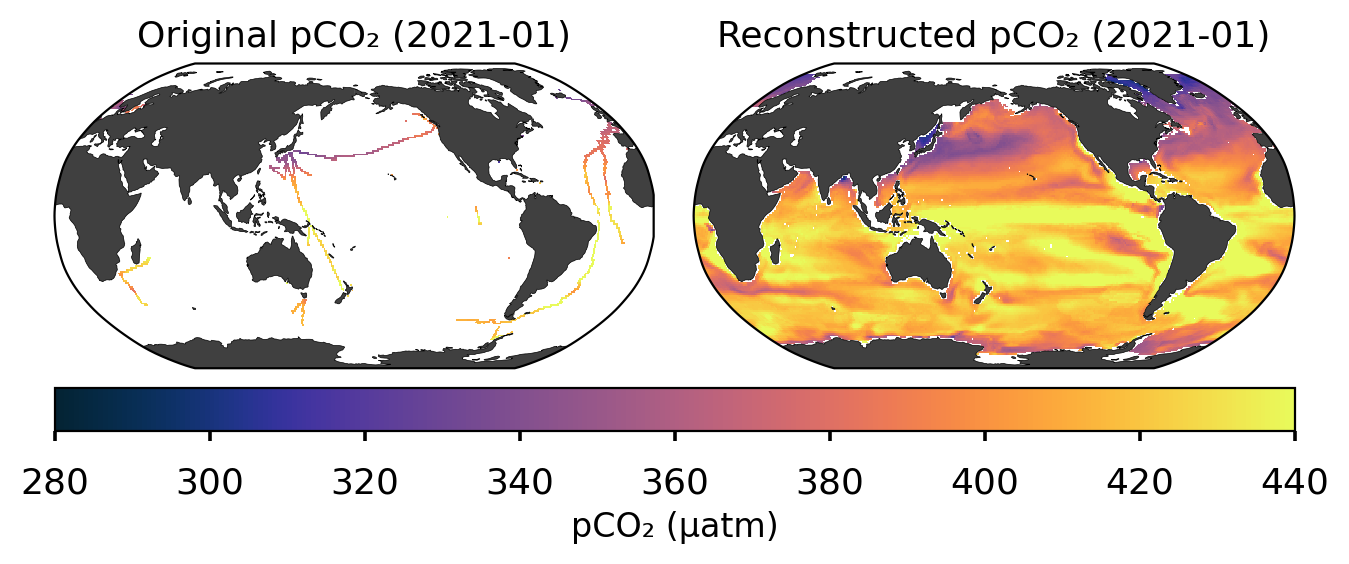

In [24]:
# Plot settings
plot_style = "seaborn-v0_8-talk"
cmap = cm.cm.thermal
cbar_title = 'pCO₂ (µatm)'
vrange = [280, 440]  # Colorbar range

# Select the first ensemble and member from the dictionary
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]

# Load original member data from ESM output
member_dir = f"{ensemble_dir}/{first_ens}/{first_mem}"
member_path = fs.glob(f"{member_dir}/*.zarr")[0]
# member_data = xr.open_mfdataset('gs://' + member_path, engine='zarr').sel(time=slice(str(dates[0]), str(dates[-1])))
member_data = xr.open_zarr('gs://' + member_path).sel(time=slice(str(dates[0]), str(dates[-1])))

# Load reconstructed pCO₂ data
recon_dir = f"{recon_output_dir}/{first_ens}/{first_mem}"    
recon_path = f"{recon_dir}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
full = xr.open_zarr(recon_path, consolidated=True)["pCO2_recon_full"]

# Choose a specific month to visualize
chosen_time = '2021-01'
raw_data = member_data["spco2"].sel(time=chosen_time).squeeze()
recon_data = full.sel(time=chosen_time)[0, ...]

# Shift longitudes from [0, 360] to [-180, 180] for global plotting
raw_data = raw_data.roll(xlon=len(raw_data.xlon) // 2, roll_coords=True)
recon_data = recon_data.roll(xlon=len(recon_data.xlon) // 2, roll_coords=True)

# Load SOCAT mask and align longitude
mask = socat_mask_data.sel(time=chosen_time)["socat_mask"].squeeze()
mask = mask.roll(xlon=len(mask.xlon) // 2, roll_coords=True)

# Mask original data where SOCAT mask == 0
masked_raw = np.ma.masked_array(raw_data, mask=(mask == 0))

# Start plotting side-by-side
with plt.style.context(plot_style):
#    fig = plt.figure(figsize=(10, 4), dpi=200)
    fig = plt.figure(figsize=(8, 3), dpi=200)
    worldmap = SpatialMap2(
        fig=fig, region='world',
        cbar_mode='single',  # Use one shared colorbar
        colorbar=True,
        cbar_location='bottom',
        nrows_ncols=[1, 2]
    )

    # Plot original (masked) and reconstructed data
    sub0 = worldmap.add_plot(
        lon=raw_data['xlon'], lat=raw_data['ylat'], data=masked_raw,
        vrange=vrange, cmap=cmap, ax=0
    )
    sub1 = worldmap.add_plot(
        lon=recon_data['xlon'], lat=recon_data['ylat'], data=recon_data,
        vrange=vrange, cmap=cmap, ax=1
    )

    worldmap.set_title("Original pCO₂ (2021-01)", ax=0, fontsize=13)
    worldmap.set_title("Reconstructed pCO₂ (2021-01)", ax=1, fontsize=13)

    colorbar = worldmap.add_colorbar(sub0, ax=0)
    worldmap.set_cbar_xlabel(colorbar, cbar_title, fontsize=12)

    plt.show()


The figure compares the original sparse pCO₂ selected from the first ESM member, consistent with real-world sampling, and the corresponding machine-learning-based reconstruction for January 2021.

# 5. Evaluation of the reconstruction against the original model output

## 5.1 Create a combined dataset with reconstruction and original 

We concatenate the outputs and ground truth from all members and ESMs into a single dataset, and then use this combined dataset to calculate bias, RMSE, and correlation.

In [25]:
datasets = []
for ensemble, members in selected_mems_dict.items():
    mems_dict = {ensemble: members}  
    ds = concat_datasets(mems_dict, recon_output_dir = recon_output_dir, init_date = init_date, fin_date=fin_date)
    datasets.append(ds)
concated_dataset = xr.concat(datasets, dim="ens")
evaluator = XarrayEvaluator(concated_dataset)

ds_eval = evaluator.compute_all_metrics()
print(ds_eval)

<xarray.Dataset> Size: 3GB
Dimensions:      (member: 8, ylat: 180, time: 240, xlon: 360, ens: 3)
Coordinates:
  * member       (member) object 64B 'member_r10i1p1f1' ... 'member_r5i1p1f1'
  * ylat         (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * xlon         (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * ens          (ens) object 24B 'ACCESS-ESM1-5' 'CanESM5' 'MPI-ESM1-2-LR'
Data variables:
    bias         (ens, member, time, ylat, xlon) float64 3GB dask.array<chunksize=(1, 1, 100, 45, 90), meta=np.ndarray>
    rmse         (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>
    correlation  (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>


## 5.2 Descriptive Statistics

We can use ds_eval to easily compute descriptive statistics. In this example, we take the average across all time steps and ESMs:

In this example, we select the Northern Hemisphere (ylat from 0 to 90), flatten the spatial dimensions, drop missing values, and generate a summary using describe(). This gives us a statistical overview (mean, std, min, max, etc.) of the bias in the Northern Hemisphere.

You can change the selection for other regions and timeframes and ensemble members.

In [26]:
ds_eval_mean = (ds_eval['bias']*1).mean('ens').mean('time')
ds_eval_mean.sel(ylat=slice(0,90)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

count    95688.000000
mean        -0.429556
std          3.210580
min        -54.107506
25%         -1.678760
50%         -0.253749
75%          1.105874
max         20.998117
Name: bias, dtype: float64

## 5.3 Bias Visualizations
Based on this, we could visualize bias between reconstruction and model truth, averaged over the 100 ensemble members, each with a 
monthly resolution over the period init_date through fin_date. Red and blue shading indicates regions where the reconstruction is biased high or low, respectively. 

### 5.3.1 How well does the reconstruction capture the mean pCO2 field? 

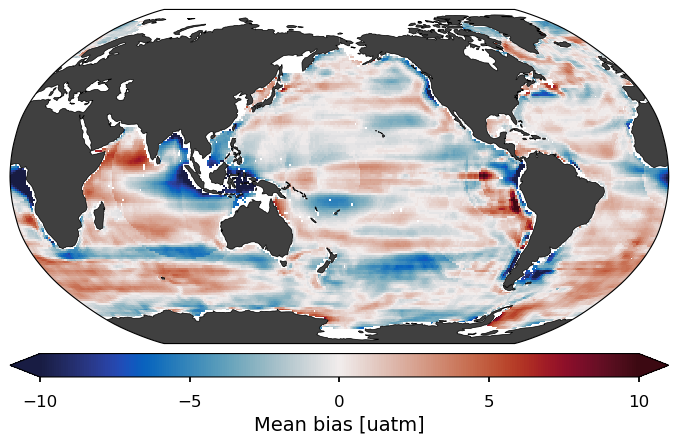

In [27]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance
    
    data = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    
    data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()


### 5.3.2 Does ESM impact the estimate of the bias? 

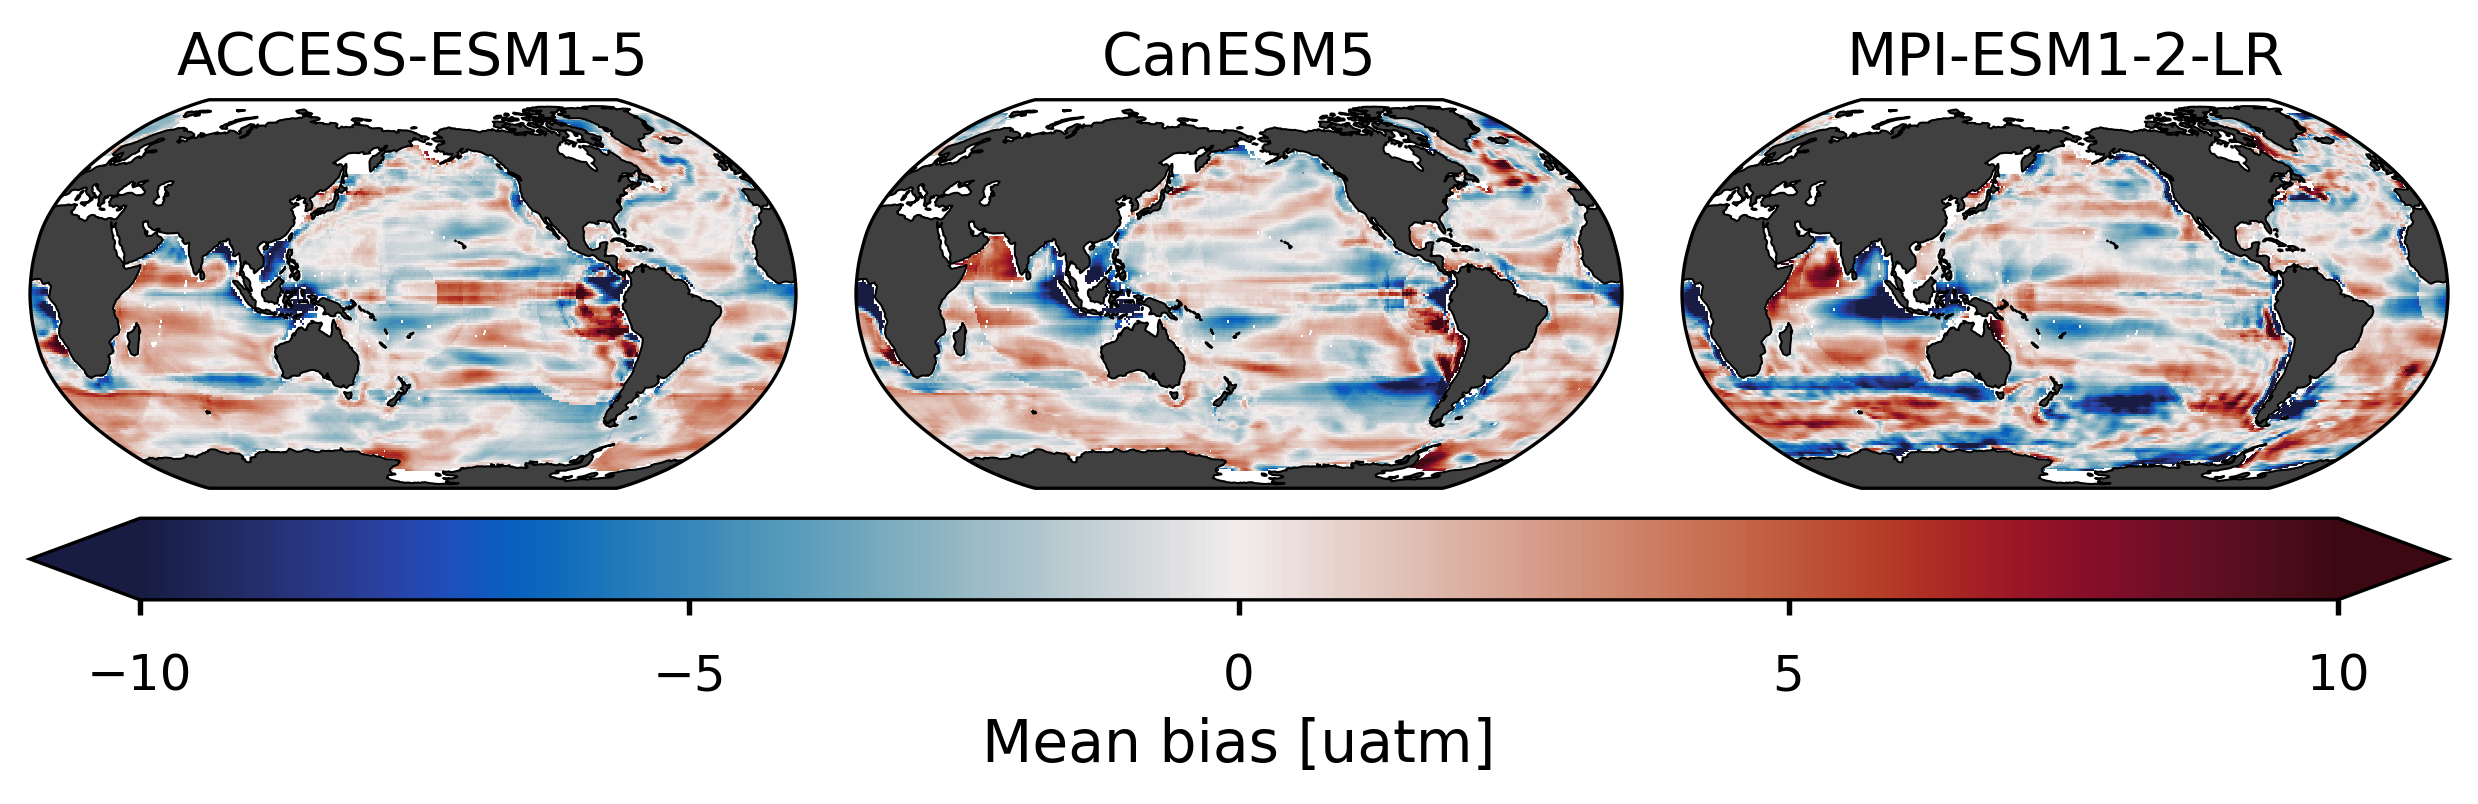

In [28]:
plot_style = "seaborn-v0_8-talk"
ensemble_means = ds_eval['bias'].mean(dim=['member', 'time'])

ensemble_names = list(ds_eval['ens'].values) 

vrange = [-10,10, 5]
cmap = cm.cm.balance

num_ensemble = len(ensemble_names)  
num_cols = 3  
num_rows = (num_ensemble + num_cols - 1) // num_cols 
with plt.style.context(plot_style):
    fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[num_rows, num_cols]) 
    for i in range(num_ensemble):
        data = ensemble_means.isel(ens=i)
        data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)  
        data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
        sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                                vrange=vrange[0:2], cmap=cmap, ax=i, linewidth_coast=0.5)
        worldmap.set_title(title=ensemble_names[i], ax=i, fontsize=14)

    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)

    worldmap.set_ticks(col, tmin=vrange[0], tmax=vrange[1], dt=vrange[2])

    col.ax.tick_params(labelsize=12)

    plt.show()


##  5.2 Reconstructed variability on seasonal, sub-decadal, and decadal timescales, compared to original model

Before computing spatial correlation metrics, we decompose both the reconstructed and reference pCO₂ fields into their long-term trend, seasonal cycle, and residual components using STL-like decomposition. We then evaluate their agreement by calculating gridwise correlation and standard deviation for each component across all ensemble members and ESMs.


In [29]:
# The calculation of these statistics takes about 1 min/member
ds_eval_corr = eval_spatial(selected_mems_dict, recon_output_dir, init_date, fin_date)

Starting computation for ESM: ACCESS-ESM1-5, Member: member_r10i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r5i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r2i1p1f1
Starting computation for ESM: CanESM5, Member: member_r2i1p1f1
Starting computation for ESM: CanESM5, Member: member_r1i1p2f1
Starting computation for ESM: CanESM5, Member: member_r1i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r12i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r11i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r15i1p1f1


Phasing of reconstruction variability on seasonal, sub-decadal, and decadal, compared to original model. Correlation between 
reconstruction and original model on (a) seasonal, (b) sub-decadal, and (c) decadal time scales. 

Here, the average correlations across all ensemble members are shown. 

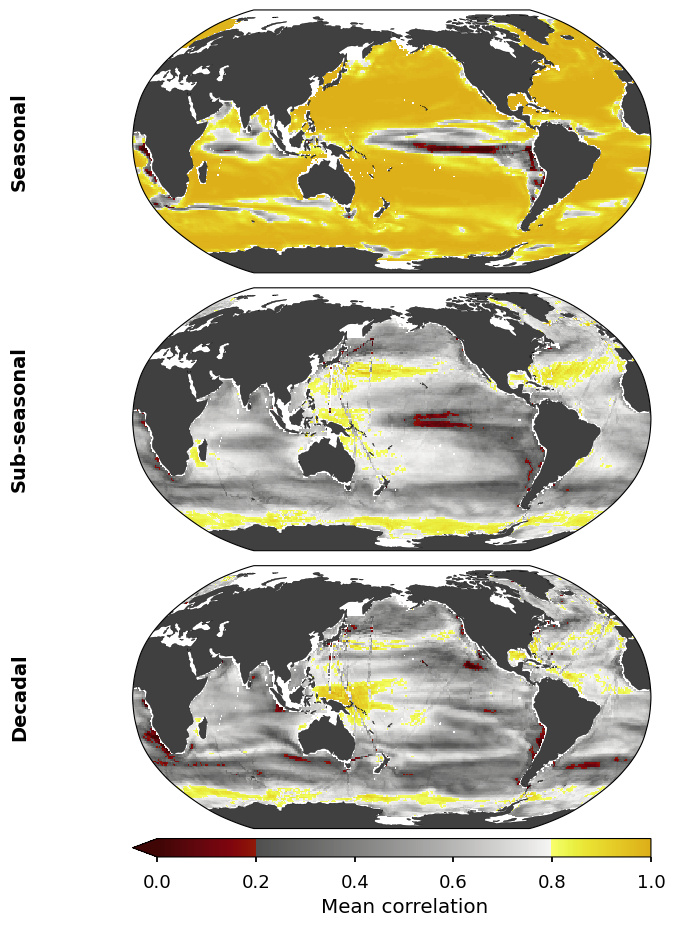

In [30]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    # Setup Figure
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world',
                   cbar_mode='edge',
                   axes_pad=0.15,
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[3,1])
    
    # Colorbar ranges
    vrange_col1 = [0, 1, 0.2]
    cmap_col1 = cm.cm.oxy
    
    ##-----------------------------------------------------
    ## Ensemble mean
    ##-----------------------------------------------------
    # Correlation - Annual-variation
    data = ds_eval_corr['corr_seasonal'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)

    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub0 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=0)
    
    
    # Correlation - sub-decadal
    data = ds_eval_corr['corr_residual'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub2 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=1)
    
    # Correlation - decadal
    data = ds_eval_corr['corr_dec'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub4 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=2)
    
    # add colorbar
    col1 = worldmap.add_colorbar(sub0, ax=0, extend='min')
    worldmap.set_cbar_xlabel(col1, f'Mean correlation')
    worldmap.set_ticks(col1, vrange_col1[0], vrange_col1[1], vrange_col1[2])

    worldmap.grid[0].text(-0.2, 0.5, "Seasonal", transform=worldmap.grid[0].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
    
    worldmap.grid[1].text(-0.2, 0.5, "Sub-seasonal", transform=worldmap.grid[1].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
    
    worldmap.grid[2].text(-0.2, 0.5, "Decadal", transform=worldmap.grid[2].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)

    
    plt.show()

The reconstructed pCO₂ has highest fidelity on seasonal timescales, but is less accurate for sub-seasonal and decadal timescale variability. 

### **Final Check for Redundant Files**  

#### **For Both Owners and Reviewers:**  
After execution is complete, review the project directory for any redundant files. Ensure that only necessary and relevant files are retained.  

#### **For Reviewers:**  
Once you have finished reviewing a project, you may delete files related to that project to free up storage space. However, be careful not to remove any data you still need.

As an **owner**, your reconstruction data is stored under:  

```
gs://leap-persistent/{owner_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/
```

If you are **reviewing someone else’s project**, their data and experiment results will be stored under your username in the following path:  

```
gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/
```

After completing the review, you can delete the files under `{owner_username}` in your directory to free up storage space. This ensures that only necessary data is retained while removing redundant files from past reviews.

# 6. Additional Information and Further Reading

This Python-based JupyterNotebook and associated utility files have been developed for Project 3 in the course EESC4243/STAT4243/5243 "Climate Prediction Challenges with Machine Learning", Professor Galen McKinley in DEES and Professor Tian Zheng in Statistics, Spring 2025 at Columbia University. The course is also a contribution from the NSF-supported LEAP STC and is intended to run on the LEAP-Pangeo cloud computing and data system. The Github repository for this course is at https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges

Code developed by Course TA Xinyi Ke and Professor Galen McKinley, following from prior work from Dr. Thea Heimdal and Abby Shaum


Additional references in which these methods are employed\
**Heimdal et al. (2024)** *"Assessing improvements in global ocean pCO₂ machine learning reconstructions with Southern Ocean autonomous sampling."* **Biogeosciences** 21: 2159–2176.  
([DOI: 10.5194/bg-21-2159-2024](https://doi.org/10.5194/bg-21-2159-2024))\
**Heimdal, T. H., & McKinley, G. A. (2024)** *"The importance of adding unbiased Argo observations to the ocean carbon observing system."* **Scientific Reports**, 14(1), 19763. ([DOI: 10.1038/s41598-024-70617-x](https://doi.org/10.1038/s41598-024-70617-x) )


In [9]:
# Temporal Response Analysis for Ocean Carbon Reconstruction
# =========================================================

import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import matplotlib.pyplot as plt
import datetime
import os
import sys
import cmocean as cm
import random
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner notebook output

# Set plotting style
plt.style.use('seaborn-v0_8-talk')

In [10]:
# =========================================================
# Dataset Loading and Preparation
# =========================================================

# Initialize GCS filesystem
fs = gcsfs.GCSFileSystem()

# Set paths for data access
ensemble_dir = "gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members"
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"
xco2_path = f"{zarr_dir}/xco2_cmip6_183501-224912_monthstart.zarr"
topo_path = f"{zarr_dir}/GEBCO_2014_1x1_global.zarr"
lsmask_path = f"{zarr_dir}/lsmask.zarr"

# Set date range
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'
dates = pd.date_range(start=date_range_start, end=date_range_end, freq='MS')

# Format dates for file naming
init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

# Import supporting functions
# Change to the parent directory if needed
if not os.path.exists('lib'):
    os.chdir(os.path.dirname(os.getcwd()))
    
# Import helper modules
from lib.visualization import SpatialMap2, xr_add_cyclic_point
from lib.residual_utils import network_mask, calc_anom, calc_interannual_anom, log_or_0

print("Current working directory:", os.getcwd())
print(f"Date range: {dates[0].strftime('%Y-%m-%d')} to {dates[-1].strftime('%Y-%m-%d')} ({len(dates)} months)")

Current working directory: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project3-ReconstructPCO2
Date range: 2004-01-01 to 2023-12-01 (240 months)


In [11]:
# Set random seed for reproducibility
random.seed(42)

# Define the models to use
selected_ensembles = ['ACCESS-ESM1-5', 'CanESM5', 'MPI-ESM1-2-LR']
num_members = 3  # Select 3 members from each model for analysis

# Dictionary to store all available members
mems_dict = {}

# Get all paths from the ensemble directory
all_paths = fs.ls(ensemble_dir)

# Populate the dictionary with available members for each model
for ens_path in all_paths:
    ens = ens_path.split('/')[-1]
    if ens in selected_ensembles:
        mems = fs.ls(ens_path)
        for mem in mems:
            memo = mem.split('/')[-1]
            if ens not in mems_dict:
                mems_dict[ens] = [memo]
            else:
                mems_dict[ens].append(memo)

# Select a subset of members from each model
selected_mems_dict = {}
for ens, members in mems_dict.items():
    if len(members) >= num_members:
        selected_mems_dict[ens] = random.sample(members, num_members)
    else:
        selected_mems_dict[ens] = members

print("Selected models and members:")
for ens, members in selected_mems_dict.items():
    print(f"  {ens}: {', '.join(members)}")

Selected models and members:
  ACCESS-ESM1-5: member_r5i1p1f1, member_r1i1p1f1, member_r10i1p1f1
  CanESM5: member_r4i1p1f1, member_r3i1p2f1, member_r9i1p1f1
  MPI-ESM1-2-LR: member_r18i1p1f1, member_r16i1p1f1, member_r7i1p1f1


In [12]:
def load_model_data(ens, member):
    """
    Load model data for a specific ensemble member.
    
    Parameters:
    -----------
    ens : str
        Earth System Model name (e.g., 'ACCESS-ESM1-5')
    member : str
        Ensemble member ID (e.g., 'member_r1i1p1f1')
        
    Returns:
    --------
    xarray.Dataset
        Dataset containing pCO2, SST, SSS, and other variables
    """
    print(f"Loading data for {ens}, {member}...")
    
    # Get paths to data files
    member_dir = f"{ensemble_dir}/{ens}/{member}"
    member_path = fs.glob(f"{member_dir}/{ens}*.zarr")[0]
    
    # Load member data
    member_data = xr.open_zarr('gs://'+member_path).sel(time=slice(str(dates[0]), str(dates[-1])))
    
    # Load atmospheric CO2 data
    xco2_data = xr.open_zarr(xco2_path).sel(time=slice(str(dates[0]), str(dates[-1])))
    
    # Create dataset with selected variables
    ds = xr.Dataset({
        'spco2': member_data.spco2,  # Surface pCO2
        'sst': member_data.sst,      # Sea Surface Temperature
        'sss': member_data.sss,      # Sea Surface Salinity
        'mld': member_data.mld,      # Mixed Layer Depth
        'pco2_T': member_data.pco2_T,  # Temperature-driven component of pCO2
    })
    
    # Add atmospheric CO2 (broadcast to same dimensions)
    ds['xco2'] = xr.ones_like(ds.sst) * xco2_data.xco2
    
    # Calculate wind stress magnitude from components if available
    if hasattr(member_data, 'tauu') and hasattr(member_data, 'tauv'):
        # Zonal and meridional wind stress components
        ds['tauu'] = member_data.tauu  
        ds['tauv'] = member_data.tauv
        # Calculate wind stress magnitude
        ds['wind_stress'] = np.sqrt(ds.tauu**2 + ds.tauv**2)
    elif 'tauu' in member_data and 'tauv' in member_data:
        # Alternative access method
        ds['tauu'] = member_data['tauu']
        ds['tauv'] = member_data['tauv']
        ds['wind_stress'] = np.sqrt(ds['tauu']**2 + ds['tauv']**2)
    
    # Add land-sea mask
    try:
        mask = network_mask(topo_path, lsmask_path)
        ds['mask'] = xr.ones_like(ds.sst.isel(time=0)) * mask.values
    except Exception as e:
        print(f"Could not add mask due to error: {e}")
        ds['mask'] = xr.ones_like(ds.sst.isel(time=0))
    
    # Ensure times are datetime objects
    if not np.issubdtype(ds.time.dtype, np.datetime64):
        ds = ds.assign_coords(time=pd.DatetimeIndex(ds.time.values))
    
    return ds

Loading data for ACCESS-ESM1-5, member_r5i1p1f1...

Dataset contents:
<xarray.Dataset> Size: 498MB
Dimensions:  (time: 240, xlon: 360, ylat: 180)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * xlon     (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * ylat     (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    sector   int32 4B ...
Data variables:
    spco2    (time, ylat, xlon) float64 124MB dask.array<chunksize=(137, 180, 360), meta=np.ndarray>
    sst      (time, ylat, xlon) float32 62MB dask.array<chunksize=(137, 180, 360), meta=np.ndarray>
    sss      (time, ylat, xlon) float32 62MB dask.array<chunksize=(137, 180, 360), meta=np.ndarray>
    mld      (time, ylat, xlon) float32 62MB dask.array<chunksize=(137, 180, 360), meta=np.ndarray>
    pco2_T   (time, ylat, xlon) float64 124MB dask.array<chunksize=(137, 180, 360), meta=np.ndarray>
    xco2     (time, ylat, xlon) float32 62MB dask.array<chunksize=

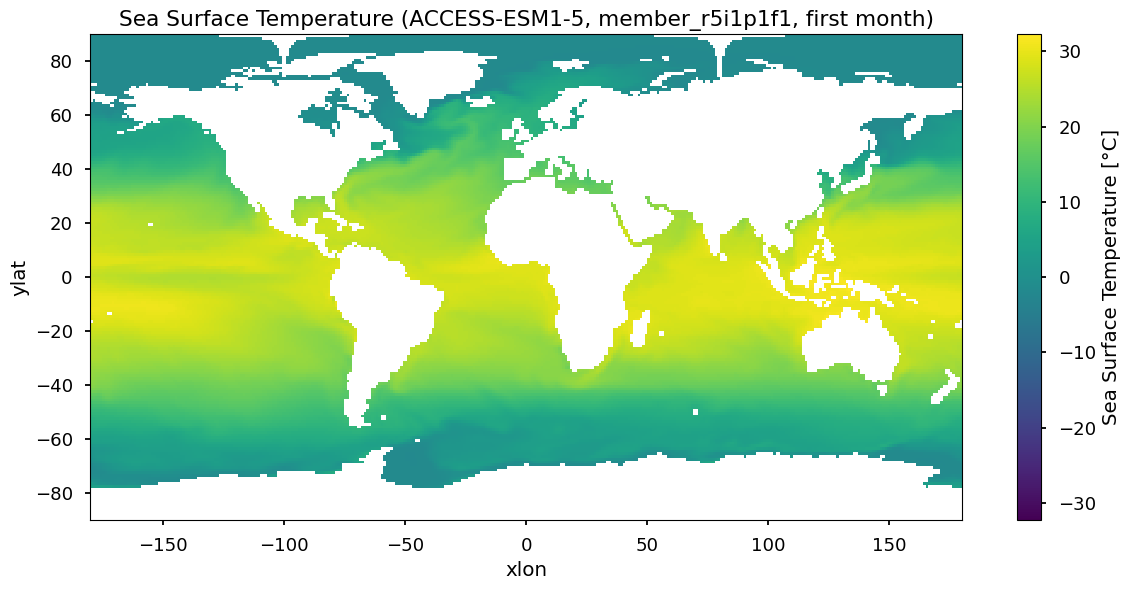

In [13]:
# Get the first model and member
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]

# Load data for this member
ds_first = load_model_data(first_ens, first_mem)

# Print dataset information
print("\nDataset contents:")
print(ds_first)

# Plot a global map of SST for visualization
plt.figure(figsize=(12, 6))
ds_first.sst.isel(time=0).plot(cmap='viridis')
plt.title(f'Sea Surface Temperature ({first_ens}, {first_mem}, first month)')
plt.tight_layout()
plt.show()

Loading data for ACCESS-ESM1-5, member_r5i1p1f1...


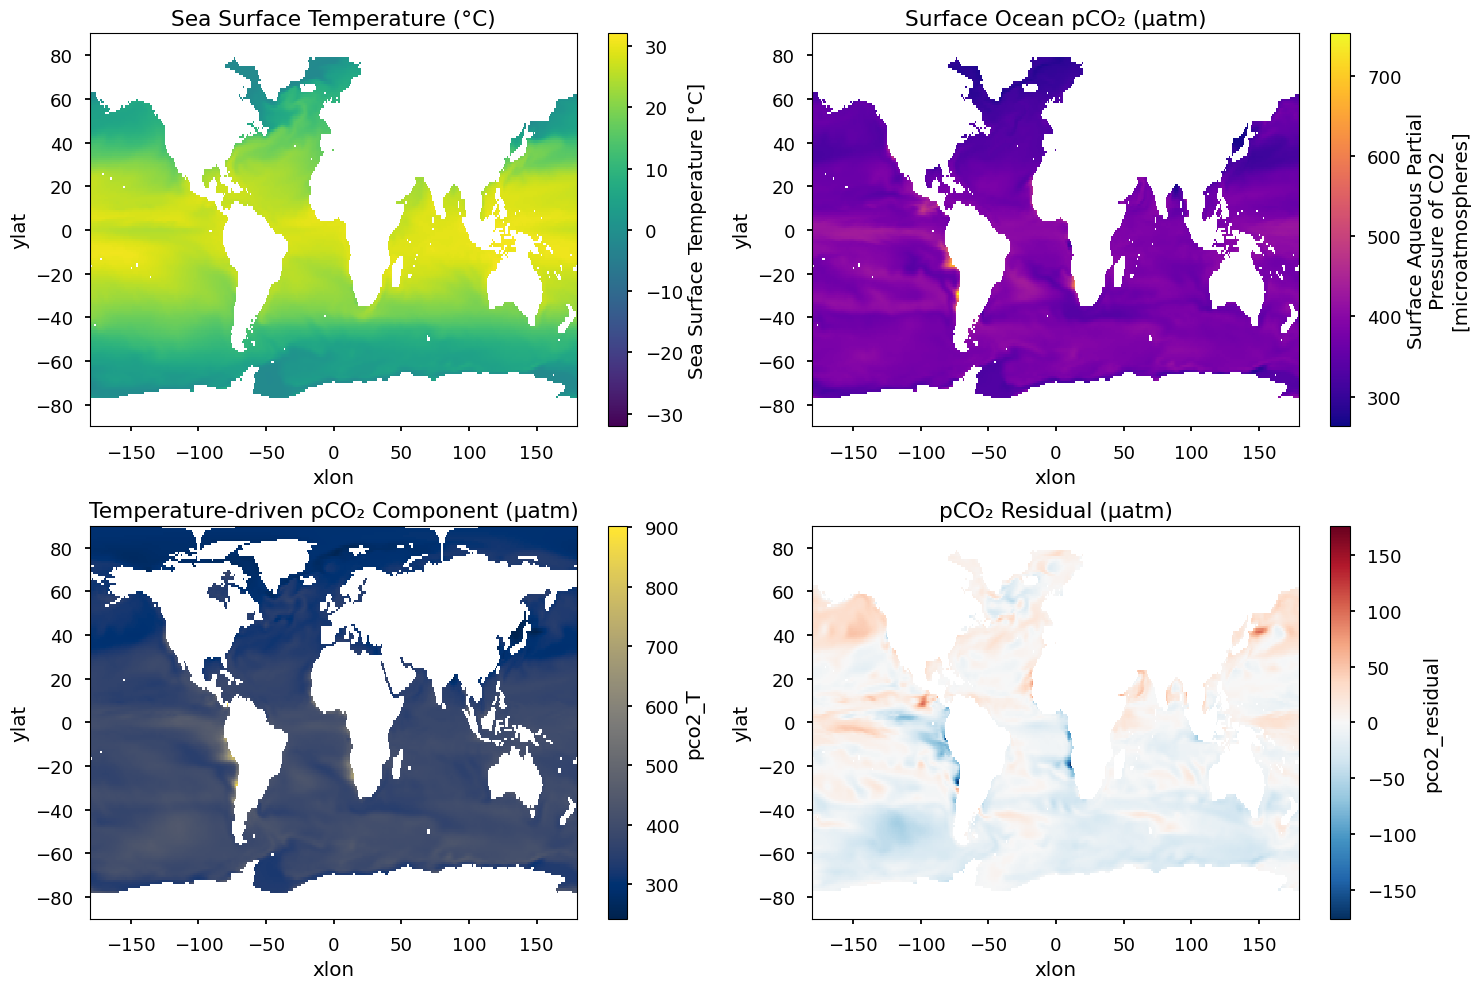

In [14]:
# =========================================================
# Dataset Alignment and Preparation
# =========================================================

def align_variables(ds):
    """
    Ensure all variables are properly aligned in space and time,
    calculate derived variables, and prepare for lag analysis.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing raw model output
        
    Returns:
    --------
    xarray.Dataset
        Processed dataset ready for lag analysis
    """
    # Ensure all variables have the same dimensions and coordinates
    common_vars = ['spco2', 'sst', 'sss', 'mld', 'xco2']
    if 'wind_stress' in ds:
        common_vars.append('wind_stress')
    
    # Calculate the pCO₂ residual
    if 'pco2_T' in ds:
        ds['pco2_residual'] = ds['spco2'] - ds['pco2_T']
        common_vars.append('pco2_residual')
    
    # Create a common mask for valid ocean points
    if 'mask' in ds:
        ocean_mask = ds['mask'] > 0
        
        # Apply mask to all variables
        for var in common_vars:
            if var in ds:
                ds[var] = ds[var].where(ocean_mask)
    
    # Calculate anomalies for each variable (if needed for analysis)
    for var in ['sst', 'sss', 'spco2']:
        if var in ds:
            # Calculate climatological monthly means
            climatology = ds[var].groupby('time.month').mean('time')
            # Calculate anomalies by subtracting the climatology 
            anomaly = ds[var].groupby('time.month') - climatology
            # Add to dataset
            ds[f'{var}_anom'] = anomaly
    
    # Calculate seasonal cycle (useful for some analyses)
    for var in ['sst', 'spco2']:
        if var in ds:
            # Extract the climatological seasonal cycle
            ds[f'{var}_seasonal'] = ds[var].groupby('time.month').mean('time')
    
    return ds

# Create function to load and process all selected members
def load_all_members(selected_dict):
    """
    Load and process data for all selected ensemble members
    
    Parameters:
    -----------
    selected_dict : dict
        Dictionary of selected models and members
        
    Returns:
    --------
    dict
        Dictionary containing processed datasets for each model and member
    """
    all_data = {}
    
    for ens, members in selected_dict.items():
        all_data[ens] = {}
        
        for mem in members:
            # Load raw data
            ds = load_model_data(ens, mem)
            
            # Align variables and prepare for analysis
            ds_aligned = align_variables(ds)
            
            # Store in dictionary
            all_data[ens][mem] = ds_aligned
            
            # Print summary of variables and dimensions
            print(f"\nAligned dataset for {ens}, {mem}:")
            print(f"Dimensions: {dict(ds_aligned.dims)}")
            print(f"Variables: {list(ds_aligned.data_vars)}")
    
    return all_data

# Load first ensemble member to examine structure
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]
ds_first = load_model_data(first_ens, first_mem)
ds_aligned = align_variables(ds_first)

# Visualize variables before proceeding with full loading
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot SST
ds_aligned.sst.isel(time=0).plot(ax=axes[0, 0], cmap='viridis')
axes[0, 0].set_title('Sea Surface Temperature (°C)')

# Plot Surface pCO₂ 
ds_aligned.spco2.isel(time=0).plot(ax=axes[0, 1], cmap='plasma')
axes[0, 1].set_title('Surface Ocean pCO₂ (μatm)')

# Plot Temperature-driven pCO₂ component
if 'pco2_T' in ds_aligned:
    ds_aligned.pco2_T.isel(time=0).plot(ax=axes[1, 0], cmap='cividis')
    axes[1, 0].set_title('Temperature-driven pCO₂ Component (μatm)')

# Plot pCO₂ residual
if 'pco2_residual' in ds_aligned:
    ds_aligned.pco2_residual.isel(time=0).plot(ax=axes[1, 1], cmap='RdBu_r')
    axes[1, 1].set_title('pCO₂ Residual (μatm)')

plt.tight_layout()
plt.show()

# Uncomment the next line when ready to load all members
# all_data = load_all_members(selected_mems_dict)

In [15]:
# =========================================================
# Dataset Alignment and Preparation with Robust NaN Handling
# =========================================================

def align_variables(ds, allowed_nan_frac=0.2):
    """
    Ensure all variables are properly aligned in space and time,
    calculate derived variables, handle NaNs robustly, and prepare for lag analysis.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing raw model output
    allowed_nan_frac : float
        Maximum fraction of allowed NaNs per spatial pixel
        
    Returns:
    --------
    xarray.Dataset
        Processed dataset ready for lag analysis
    """
    import numpy as np
    
    # Essential variables for the analysis
    common_vars = ['spco2', 'sst', 'sss', 'mld', 'xco2']
    if 'wind_stress' in ds:
        common_vars.append('wind_stress')
    
    # Calculate the pCO₂ residual
    if 'pco2_T' in ds:
        ds['pco2_residual'] = ds['spco2'] - ds['pco2_T']
        common_vars.append('pco2_residual')
    
    # Create a common mask for valid ocean points (from mask variable if exists)
    if 'mask' in ds:
        ocean_mask = ds['mask'] > 0
    else:
        ocean_mask = xr.ones_like(ds[common_vars[0]].isel(time=0), dtype=bool)
    
    # Combine with NaN-based mask: Calculate pixels that exceed allowed NaNs
    nan_masks = []
    for var in common_vars:
        if var in ds:
            nan_fraction = ds[var].isnull().mean(dim='time')
            nan_mask = nan_fraction <= allowed_nan_frac
            nan_masks.append(nan_mask)
            
            # Fix here: compute explicitly to get integer count
            invalid_count = int((~nan_mask).sum().compute())
            print(f"'{var}': {invalid_count} pixels exceed allowed NaN fraction.")
    
    # Combine all masks into a single robust global mask
    combined_mask = ocean_mask & np.logical_and.reduce(nan_masks)
    valid_pixel_count = int(combined_mask.sum().compute())
    print(f"Total valid pixels for analysis: {valid_pixel_count}")
    
    # Apply the global mask to all variables explicitly
    for var in common_vars:
        if var in ds:
            ds[var] = ds[var].where(combined_mask)
    
    # Calculate anomalies for essential variables
    for var in ['sst', 'sss', 'spco2']:
        if var in ds:
            climatology = ds[var].groupby('time.month').mean('time')
            anomaly = ds[var].groupby('time.month') - climatology
            ds[f'{var}_anom'] = anomaly.where(combined_mask)
    
    # Calculate seasonal cycle for relevant variables
    for var in ['sst', 'spco2']:
        if var in ds:
            ds[f'{var}_seasonal'] = ds[var].groupby('time.month').mean('time').where(combined_mask)
    
    return ds



Loading data for ACCESS-ESM1-5, member_r5i1p1f1...
'spco2': 23905 pixels exceed allowed NaN fraction.
'sst': 23905 pixels exceed allowed NaN fraction.
'sss': 23905 pixels exceed allowed NaN fraction.
'mld': 23905 pixels exceed allowed NaN fraction.
'xco2': 0 pixels exceed allowed NaN fraction.
'pco2_residual': 23905 pixels exceed allowed NaN fraction.
Total valid pixels for analysis: 33682


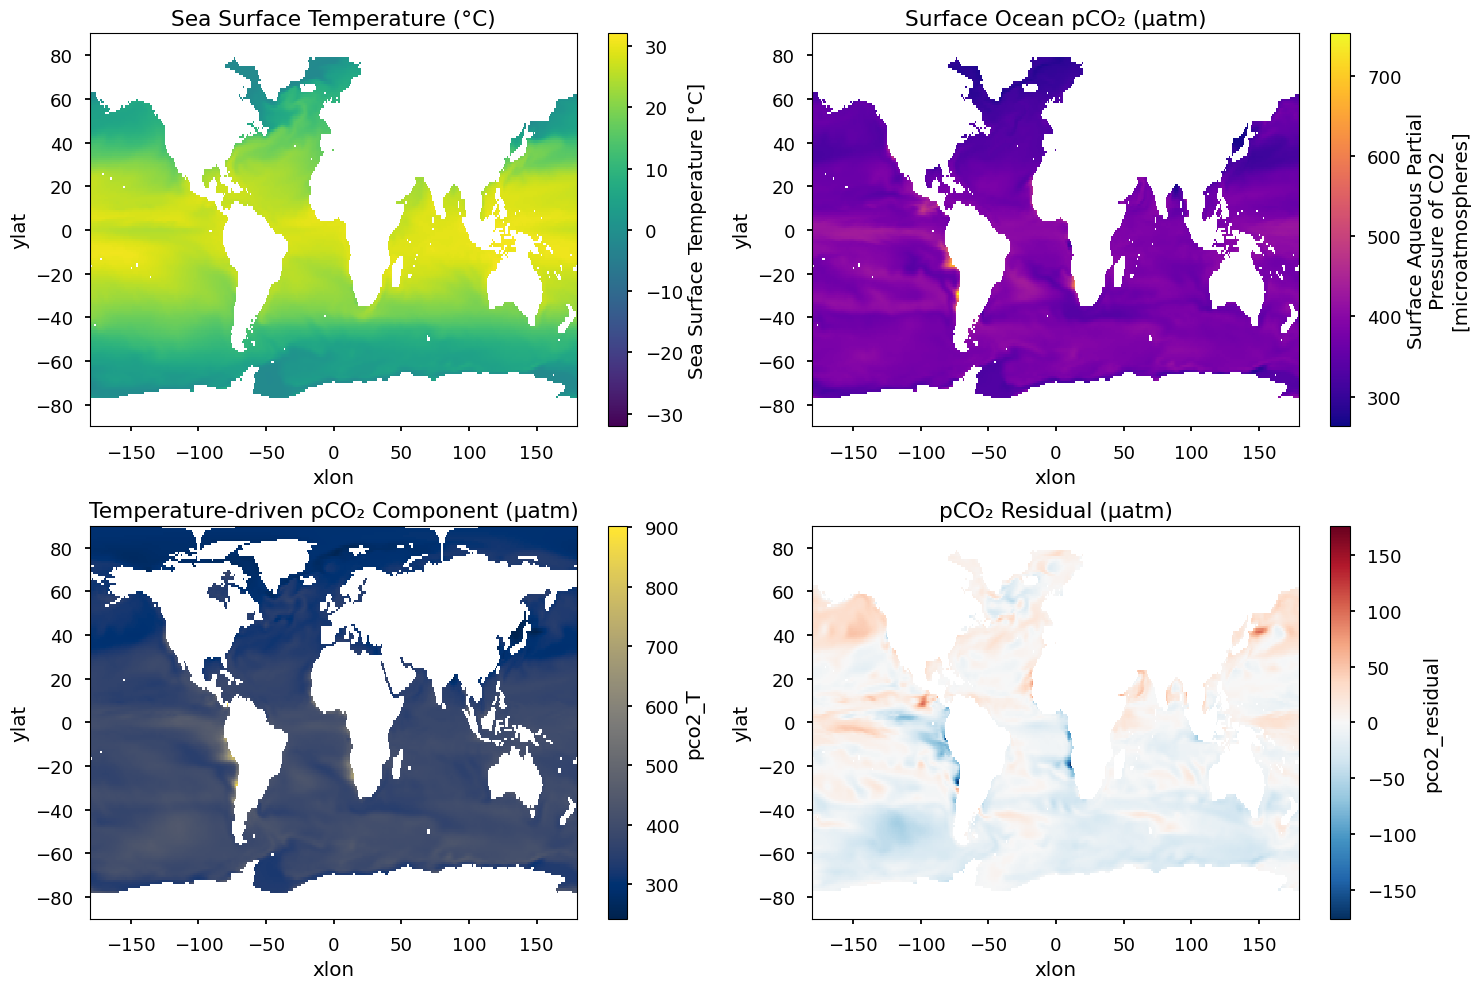

In [16]:
# Load first ensemble member to examine structure with robust NaN handling
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]

# Load the dataset (assuming load_model_data is defined and accessible)
ds_first = load_model_data(first_ens, first_mem)

# Apply robust alignment and NaN handling (e.g., allowing max 20% NaNs)
ds_aligned = align_variables(ds_first, allowed_nan_frac=0.2)
# Quick visualization check
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# SST
ds_aligned.sst.isel(time=0).plot(ax=axes[0, 0], cmap='viridis')
axes[0, 0].set_title('Sea Surface Temperature (°C)')

# Surface pCO₂
ds_aligned.spco2.isel(time=0).plot(ax=axes[0, 1], cmap='plasma')
axes[0, 1].set_title('Surface Ocean pCO₂ (μatm)')

# Temperature-driven pCO₂ component
if 'pco2_T' in ds_aligned:
    ds_aligned.pco2_T.isel(time=0).plot(ax=axes[1, 0], cmap='cividis')
    axes[1, 0].set_title('Temperature-driven pCO₂ Component (μatm)')

# pCO₂ residual
if 'pco2_residual' in ds_aligned:
    ds_aligned.pco2_residual.isel(time=0).plot(ax=axes[1, 1], cmap='RdBu_r')
    axes[1, 1].set_title('pCO₂ Residual (μatm)')

plt.tight_layout()
plt.show()


In [17]:
# Check if pco2_T is available in the loaded dataset
def examine_dataset_variables(ens, member):
    """
    Check what variables are available in the dataset
    """
    member_dir = f"{ensemble_dir}/{ens}/{member}"
    member_path = fs.glob(f"{member_dir}/{ens}*.zarr")[0]
    
    # Load member data with minimal variables to check what's available
    try:
        member_data = xr.open_zarr('gs://'+member_path, consolidated=True)
        print(f"Available variables in {ens}, {member}:")
        for var in member_data.data_vars:
            print(f"  - {var}")
        
        # Check if pco2_T is available
        if 'pco2_T' in member_data:
            print("\n'pco2_T' is available in the dataset!")
        else:
            print("\n'pco2_T' is NOT available and needs to be calculated.")
            
        return list(member_data.data_vars)
    except Exception as e:
        print(f"Error examining dataset: {e}")
        return []

# Check the first ensemble member
available_vars = examine_dataset_variables(first_ens, first_mem)

Available variables in ACCESS-ESM1-5, member_r5i1p1f1:
  - chl
  - mld
  - pco2_T
  - pco2_residual
  - spco2
  - sss
  - sst

'pco2_T' is available in the dataset!


Computing lag correlation between spco2 and sst...
Computing lag correlation between spco2 and sss...
Computing lag correlation between spco2 and xco2...
Computing lag correlation between spco2 and mld...
Computing lag correlation between pco2_residual and sst...
Computing lag correlation between pco2_residual and sss...
Computing lag correlation between pco2_residual and xco2...
Computing lag correlation between pco2_residual and mld...


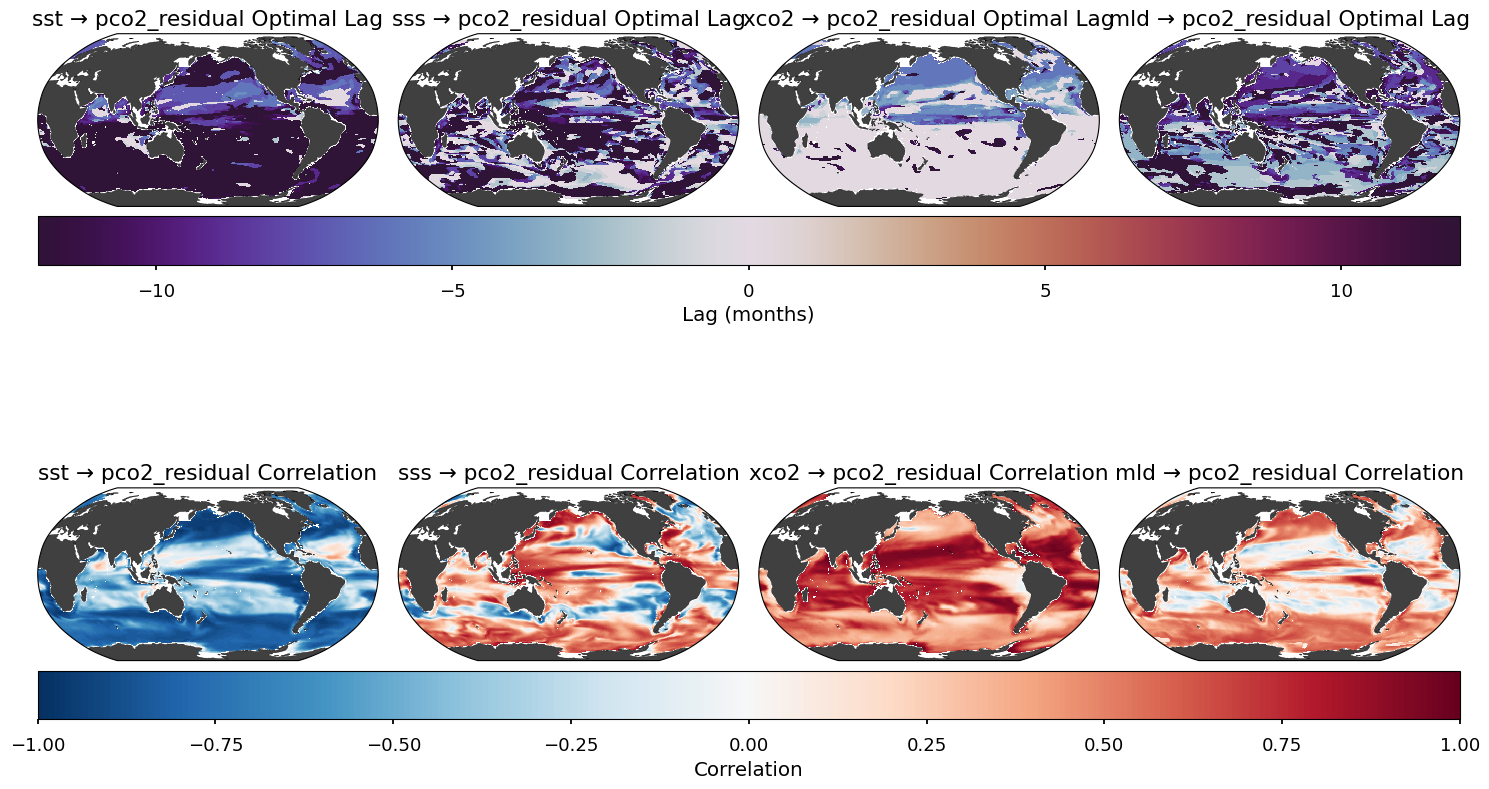

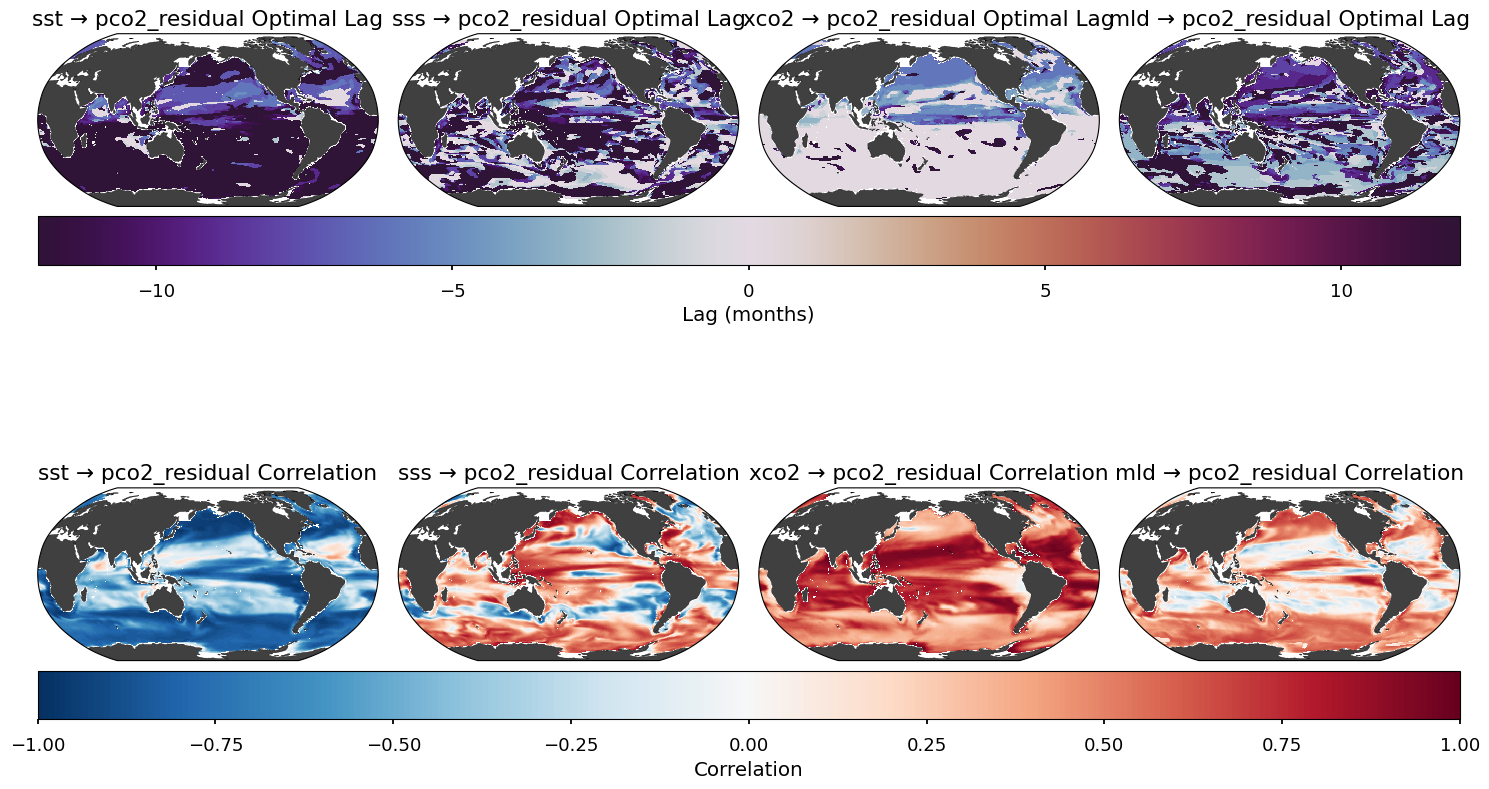

In [18]:
# =========================================================
# Temporal Lag Analysis
# =========================================================

def compute_lag_correlation(ds, target_var, driver_var, max_lag=12):
    """
    Compute lagged correlation between a target variable (e.g., pCO2 residual)
    and a driver variable (e.g., SST, wind stress) across a range of temporal lags.

    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing time-series variables
    target_var : str
        Name of the target variable (e.g., 'pco2_residual')
    driver_var : str
        Name of the driver variable (e.g., 'sst')
    max_lag : int
        Maximum lag (in months) to compute (lags will range from -max_lag to +max_lag)

    Returns:
    --------
    xarray.Dataset
        Dataset containing:
            - correlation for each lag
            - optimal lag index
            - correlation at optimal lag
            - optimal lag value
    """
    print(f"Computing lag correlation between {target_var} and {driver_var}...")

    if target_var not in ds or driver_var not in ds:
        print(f"Variables {target_var} or {driver_var} not found in dataset.")
        return None

    target = ds[target_var]
    driver = ds[driver_var]

    corr_values = []
    lag_range = range(-max_lag, max_lag + 1)

    for lag in lag_range:
        if lag > 0:
            target_shifted = target.isel(time=slice(lag, None))
            driver_shifted = driver.isel(time=slice(0, -lag))
        elif lag < 0:
            target_shifted = target.isel(time=slice(0, lag))
            driver_shifted = driver.isel(time=slice(abs(lag), None))
        else:
            target_shifted = target
            driver_shifted = driver

        if len(target_shifted.time) < 3 or len(driver_shifted.time) < 3:
            corr = xr.full_like(target.isel(time=0), np.nan)
        else:
            corr = xr.corr(target_shifted, driver_shifted, dim='time')

        corr_values.append(corr)

    # Combine correlation results into a DataArray along the lag dimension
    corr_da = xr.concat(corr_values, pd.Index(lag_range, name='lag'))

    # Handle NaNs: ensure we only compute lag indices where at least one correlation exists
    abs_corr = np.abs(corr_da)
    valid_mask = abs_corr.notnull().any(dim='lag')
    abs_corr_filled = abs_corr.where(valid_mask, other=-9999)

    # Compute the optimal lag index safely
    optimal_lag_idx = abs_corr_filled.argmax('lag').compute()
    optimal_lag_idx = optimal_lag_idx.where(valid_mask)

    # Convert lag_range to a NumPy array for safe indexing
    lag_values = np.array(list(lag_range))
    index_np = optimal_lag_idx.fillna(0).astype(int).values

    # Construct a clean indexer
    indexer = xr.DataArray(index_np, dims=('ylat', 'xlon'),
                           coords={'ylat': corr_da.ylat, 'xlon': corr_da.xlon})

    # Extract correlation at optimal lag
    optimal_lag = corr_da.isel(lag=indexer)
    optimal_lag = optimal_lag.where(valid_mask)

    # Extract actual lag value
    optimal_lag_value = xr.DataArray(lag_values, dims='lag').isel(lag=indexer)
    optimal_lag_value = optimal_lag_value.where(valid_mask)

    return xr.Dataset({
        'correlation': corr_da,
        'optimal_lag_correlation': optimal_lag,
        'optimal_lag_index': optimal_lag_idx,
        'optimal_lag_value': optimal_lag_value
    })



def analyze_all_drivers(ds, target_vars=['spco2', 'pco2_residual'], 
                       driver_vars=['sst', 'sss', 'wind_stress', 'xco2','mld', 'chl'], 
                       max_lag=12):
    """
    Compute lag correlations for all specified driver variables
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing variables
    target_vars : list
        List of target variables to analyze
    driver_vars : list
        List of driver variables to analyze
    max_lag : int
        Maximum lag to compute in months
        
    Returns:
    --------
    dict
        Dictionary containing lag correlation results for each combination
    """
    results = {}
    
    for target_var in target_vars:
        results[target_var] = {}
        
        for driver_var in driver_vars:
            if driver_var in ds:
                results[target_var][driver_var] = compute_lag_correlation(
                    ds, target_var, driver_var, max_lag)
    
    return results

# Run the lag analysis on the aligned dataset
max_lag = 12  # Maximum lag to consider (in months)
lag_results = analyze_all_drivers(ds_aligned, max_lag=max_lag)



def shift_to_360_and_add_cyclic(da, lon_name='xlon'):
    da = da.copy()
    if da[lon_name].max() <= 180:
        da[lon_name] = (da[lon_name] + 360) % 360
    da = da.sortby(da[lon_name])
    values, lon = add_cyclic_point(da.values, coord=da[lon_name].values)
    da_cyclic = xr.DataArray(values, dims=da.dims, coords={**da.coords, lon_name: lon})
    return da_cyclic

def plot_lag_correlation_maps_grid(results, target_var, driver_vars, max_lag=12):
    """
    Clean grid-based version of lag correlation maps using SpatialMap2.
    Each row: one driver. Left: Optimal Lag. Right: Correlation.
    """
    n_drivers = len(driver_vars)
    fig = plt.figure(figsize=(14, 5 * n_drivers))  # One row per driver, two columns each

    for i, driver_var in enumerate(driver_vars):
        if driver_var not in results[target_var]:
            continue

        lag_result = results[target_var][driver_var]
        opt_lag = shift_to_360_and_add_cyclic(lag_result['optimal_lag_value'])
        opt_corr = shift_to_360_and_add_cyclic(lag_result['optimal_lag_correlation'])

        # --- Optimal Lag subplot ---
        sm_lag = SpatialMap2(
            fig=fig, region='world', rect=[n_drivers, 2, i * 2 + 1],
            colorbar=True
        )
        sub_lag = sm_lag.add_plot(
            lon=opt_lag.xlon, lat=opt_lag.ylat, data=opt_lag,
            vrange=[-max_lag, max_lag],
            cmap=plt.get_cmap('twilight_shifted')
        )
        col_lag = sm_lag.add_colorbar(sub_lag)
        sm_lag.set_title(f'{driver_var} → {target_var} Optimal Lag', 0)
        sm_lag.set_cbar_xlabel(col_lag, 'Lag (months)')

        # --- Correlation subplot ---
        sm_corr = SpatialMap2(
            fig=fig, region='world', rect=[n_drivers, 2, i * 2 + 2],
            colorbar=True
        )
        sub_corr = sm_corr.add_plot(
            lon=opt_corr.xlon, lat=opt_corr.ylat, data=opt_corr,
            vrange=[-1, 1],
            cmap=plt.get_cmap('RdBu_r')
        )
        col_corr = sm_corr.add_colorbar(sub_corr)
        sm_corr.set_title(f'{driver_var} → {target_var} Correlation', 0)
        sm_corr.set_cbar_xlabel(col_corr, 'Correlation')

    plt.tight_layout()
    return fig

# Plot results for each driver
#for driver_var in ['sst', 'sss', 'wind_stress', 'xco2']:
 #   if driver_var in ds_aligned:
  #      plot_lag_correlation_maps(lag_results, 'pco2_residual', driver_var)

# Create maps using SpatialMap2 for better visualizations


def plot_optimal_lag_maps(results, target_var, driver_vars, max_lag=12):
    """
    Create publication-quality maps of optimal lag and correlation using SpatialMap2
    with shared colorbars and adjusted longitudes (0–360 + cyclic point).
    """
    n_drivers = len(driver_vars)
    fig = plt.figure(figsize=(15, 10))

    # Top row: Optimal Lag
    sm_lag = SpatialMap2(
        fig=fig, region='world', rect=[2, 1, 1],
        nrows_ncols=(1, n_drivers),
        colorbar=True, cbar_mode='single',
        cbar_location='bottom', cbar_pad=0.1
    )

    # Bottom row: Correlation
    sm_corr = SpatialMap2(
        fig=fig, region='world', rect=[2, 1, 2],
        nrows_ncols=(1, n_drivers),
        colorbar=True, cbar_mode='single',
        cbar_location='bottom', cbar_pad=0.1
    )

    lag_plots = []
    corr_plots = []

    for i, driver_var in enumerate(driver_vars):
        if driver_var not in results[target_var]:
            continue

        lag_result = results[target_var][driver_var]

        # Align data to 0–360 and add cyclic point
        opt_lag = shift_to_360_and_add_cyclic(lag_result['optimal_lag_value'])
        opt_corr = shift_to_360_and_add_cyclic(lag_result['optimal_lag_correlation'])

        # Plot optimal lag
        sub_lag = sm_lag.add_plot(
            lon=opt_lag.xlon, lat=opt_lag.ylat, data=opt_lag,
            vrange=[-max_lag, max_lag],
            cmap=plt.get_cmap('twilight_shifted'), ax=i
        )
        lag_plots.append(sub_lag)
        sm_lag.set_title(f'{driver_var} → {target_var} Optimal Lag', i)

        # Plot correlation
        sub_corr = sm_corr.add_plot(
            lon=opt_corr.xlon, lat=opt_corr.ylat, data=opt_corr,
            vrange=[-1, 1],
            cmap=plt.get_cmap('RdBu_r'), ax=i
        )
        corr_plots.append(sub_corr)
        sm_corr.set_title(f'{driver_var} → {target_var} Correlation', i)

    # Shared colorbars
    col_lag = sm_lag.add_colorbar(lag_plots[0], ax=0)
    sm_lag.set_cbar_xlabel(col_lag, 'Lag (months)')

    col_corr = sm_corr.add_colorbar(corr_plots[0], ax=0)
    sm_corr.set_cbar_xlabel(col_corr, 'Correlation')

    plt.tight_layout()
    return fig




# Extract sample time series to visualize the lagged relationships
def plot_regional_time_series(ds, results, target_var, driver_var, 
                             lat, lon, window=36):
    """
    Plot time series of target and driver variables at a specific location,
    highlighting the optimal lag relationship.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing variables
    results : dict
        Results dictionary from analyze_all_drivers
    target_var : str
        Target variable name
    driver_var : str
        Driver variable name
    lat, lon : float
        Latitude and longitude of location to extract
    window : int
        Number of months to display (default: 36)
    """
    # Extract point data
    point_data = ds.sel(ylat=lat, xlon=lon, method='nearest')
    
    # Get optimal lag at this location
    lag_result = results[target_var][driver_var]
    opt_lag_point = lag_result['optimal_lag_value'].sel(ylat=lat, xlon=lon, method='nearest').values
    opt_corr_point = lag_result['optimal_lag_correlation'].sel(ylat=lat, xlon=lon, method='nearest').values
    
    # Create time series plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot target variable
    target_series = point_data[target_var]
    time_window = slice(0, min(window, len(target_series.time)))
    time_values = target_series.time.values[time_window]
    
    ax1.plot(time_values, target_series.values[time_window], 'b-', 
             label=f'{target_var}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel(f'{target_var}', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Plot driver variable with optimal lag
    driver_series = point_data[driver_var]
    
    # Shift the driver series by the optimal lag
    if opt_lag_point > 0:
        # Driver leads target, shift target forward
        driver_time = time_values[:-int(opt_lag_point)] if int(opt_lag_point) < len(time_values) else []
        driver_values = driver_series.values[time_window][:len(driver_time)]
    elif opt_lag_point < 0:
        # Target leads driver, shift driver forward
        driver_time = time_values[int(abs(opt_lag_point)):] if int(abs(opt_lag_point)) < len(time_values) else []
        driver_values = driver_series.values[time_window][int(abs(opt_lag_point)):]
    else:
        # No lag
        driver_time = time_values
        driver_values = driver_series.values[time_window]
    
    ax2 = ax1.twinx()
    if len(driver_time) > 0:
        ax2.plot(driver_time, driver_values, 'r-', 
                label=f'{driver_var} (lag={int(opt_lag_point)} months)')
    ax2.set_ylabel(f'{driver_var}', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add both legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.title(f'{driver_var} → {target_var} at ({lat}°N, {lon}°E)\n'
              f'Optimal Lag: {int(opt_lag_point)} months, '
              f'Correlation: {opt_corr_point:.2f}')
    
    plt.tight_layout()
    plt.show()
    
    return fig
# Plot optimal lag maps for all drivers
drivers_to_plot = [var for var in ['sst', 'sss', 'wind_stress', 'xco2', "chl", "mld"] if var in ds_aligned]
plot_optimal_lag_maps(lag_results, 'pco2_residual', drivers_to_plot)
# plot_regional_time_series(ds_aligned, lag_results, 'pco2_residual', 'sst', 0, 180)
# plot_regional_time_series(ds_aligned, lag_results, 'pco2_residual', 'sst', 45, 330)
# plot_regional_time_series(ds_aligned, lag_results, 'pco2_residual', 'sst', -60, 180)

In [24]:
def apply_lags_to_drivers(driver_da, lag_da):
    """
    Apply pixel-specific temporal lags to a driver variable.
    
    Parameters:
    -----------
    driver_da : xarray.DataArray
        The driver variable with dimensions (time, ylat, xlon)
    lag_da : xarray.DataArray
        The precomputed optimal lag values with dimensions (ylat, xlon)
        
    Returns:
    --------
    xarray.DataArray
        The lagged driver variable with the same dimensions as the input
    """
    # Create an output array with the same shape as the driver, filled with NaNs
    lagged_driver = xr.full_like(driver_da, np.nan)

    
    # Get unique lag values to process them efficiently
    unique_lags = np.unique(lag_da.values[~np.isnan(lag_da.values)])
    
    # For each unique lag value, apply the shift to all pixels with that lag
    for lag in unique_lags:
        # Create a boolean mask for pixels with this lag value
        lag_mask = (lag_da == lag)
        
        # Skip if no pixels have this lag value
        if not np.any(lag_mask):
            continue
        
        # Apply the appropriate shift based on lag direction
        if lag == 0:
            # No shift for zero lag
            shifted_driver = driver_da
        else:
            # Shift the time dimension by the lag amount
            shifted_driver = driver_da.shift(time=int(lag))
        
        # Apply the shifted values only to pixels with this lag
        lagged_driver = lagged_driver.where(~lag_mask, shifted_driver)
    
    return lagged_driver
def create_lag_aware_dataset(ds, lag_results, target_var='pco2_residual'):
    """
    Create a dataset with lagged driver variables based on optimal lag correlation.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Original dataset with variables
    lag_results : dict
        Results from lag correlation analysis
    target_var : str
        Target variable name used in lag_results
    
    Returns:
    --------
    xarray.Dataset
        Dataset with original and lagged driver variables
    """
    print("Creating lag-aware dataset...")
    
    # Create a copy of the original dataset
    ds_lagged = ds.copy()
    
    if target_var not in lag_results:
        print(f"No lag results for target '{target_var}'. Returning original dataset.")
        return ds_lagged
    
    # Process each driver variable with lag results
    for driver_var, lag_result in lag_results[target_var].items():
        if driver_var in ds:
            print(f"  Applying optimal lags to {driver_var}...")
            
            # Get optimal lag values for this driver variable
            opt_lag_da = lag_result['optimal_lag_value']
            
            # Apply lags to the driver variable
            lagged_driver = apply_lags_to_drivers(ds[driver_var], opt_lag_da)
            
            # Add the lagged variable to the dataset
            ds_lagged[f"{driver_var}_lagged"] = lagged_driver
            
            print(f"    Created {driver_var}_lagged variable")
        else:
            print(f"  Warning: Driver variable {driver_var} not found in dataset. Skipping.")
    
    return ds_lagged
# -------------------------------------------------
# 🔧 Fixed Data Preparation Function
# -------------------------------------------------

def prepare_data_for_ml_fixed(ds, driver_vars, target_var='pco2_residual', lagged=True):
    """
    Final fixed version that uses 'mask' instead of 'socat_mask'.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing variables
    driver_vars : list
        List of driver variables to use as features
    target_var : str
        Target variable to predict
    lagged : bool
        Whether to use lagged versions of drivers
    
    Returns:
    --------
    tuple
        (X_train, X_test, y_train, y_test, features)
    """
    print("Preparing data for machine learning...")
    
    # Determine which features to use
    if lagged:
        drivers = [f"{var}_lagged" for var in driver_vars if f"{var}_lagged" in ds]
    else:
        drivers = [var for var in driver_vars if var in ds]

    # Include spatial and temporal features
    spatial_features = ['A', 'B', 'C']
    temporal_features = ['T0', 'T1']
    all_features = drivers + spatial_features + temporal_features
    
    print(f"  Using features: {all_features}")

    # Create mask for SOCAT points - using 'mask' instead of 'socat_mask'
    if 'mask' in ds:
        socat_mask = (ds['mask'] == 1)
    else:
        print("  Warning: No 'mask' variable found in dataset. Using all points.")
        socat_mask = xr.ones_like(ds[target_var].isel(time=0), dtype=bool)

    # Create mask for valid feature data (non-NaN)
    feature_mask_list = []
    for var in drivers:
        if var in ds:
            feature_mask_list.append(~ds[var].isnull())
    
    # Include target variable in mask
    if target_var in ds:
        feature_mask_list.append(~ds[target_var].isnull())

    # Combine all feature masks
    feature_mask = xr.concat(feature_mask_list, dim='features').all('features')
    
    # Final mask combines SOCAT mask and feature mask
    final_mask = socat_mask & feature_mask

    # Count valid points
    valid_points = int(final_mask.sum().compute().item())
    print(f"  Total valid SOCAT points: {valid_points}")

    # Get dimensions for reshaping
    time_len = len(ds.time)
    space_len = len(ds.ylat) * len(ds.xlon)

    # Extract features - using the same approach as original working code
    X_list = []
    
    # Driver variables (time, ylat, xlon)
    for var in drivers:
        X_list.append(ds[var].values.reshape((time_len * space_len,)))
    
    # Spatial features (ylat, xlon) - tile across time
    for var in spatial_features:
        X_list.append(np.tile(ds[var].values.flatten(), time_len))
    
    # Temporal features (time) - repeat for all spatial points
    for var in temporal_features:
        X_list.append(np.repeat(ds[var].values, space_len))

    # Stack features and extract target
    X = np.stack(X_list, axis=1)
    y = ds[target_var].values.reshape((time_len * space_len,))

    # Apply final mask to extract valid points
    final_mask_flat = final_mask.values.flatten()
    X = X[final_mask_flat]
    y = y[final_mask_flat]

    # Remove any remaining NaN values
    isnan_X = np.isnan(X).any(axis=1)
    isnan_y = np.isnan(y)
    good_idx = ~(isnan_X | isnan_y)

    X = X[good_idx]
    y = y[good_idx]

    print(f"  Final ML training points after cleaning: {X.shape[0]}")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    print(f"  Training set: {X_train.shape[0]} samples")
    print(f"  Test set: {X_test.shape[0]} samples")

    return X_train, X_test, y_train, y_test, all_features
# -------------------------------------------------
# 🔧 Fixed Reconstruction Function
# -------------------------------------------------
def train_xgboost_model(X_train, y_train, X_test, y_test, features=None):
    """
    Train an XGBoost model for pCO2 prediction.

    Parameters:
    -----------
    X_train, y_train : numpy.ndarray
        Training data
    X_test, y_test : numpy.ndarray
        Testing data
    features : list, optional
        Feature names for importance analysis

    Returns:
    --------
    xgboost.XGBRegressor
        Trained model
    """
    print("Training XGBoost model...")

    # Set XGBoost parameters
    params = {
        'n_estimators': 500,
        'max_depth': 6,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.1,
        'min_child_weight': 5,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'random_state': 42,
        'eval_metric': 'rmse'  # <-- moved here for compatibility with older versions
    }

    # Create and train model
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False
    )

    # Evaluate on test set
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"  Test set R²: {r2:.4f}")
    print(f"  Test set RMSE: {rmse:.4f} μatm")

    # Show feature importance if names are provided
    if features is not None:
        importance = model.feature_importances_
        print("\n  Feature importance:")
        for i, feat in enumerate(features):
            print(f"    {feat}: {importance[i]:.4f}")

    return model
def reconstruct_ocean_pco2_fixed(ds, ds_lagged, model, features):
    """
    Fixed reconstruction function that handles feature dimensions correctly.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Original dataset with variables
    ds_lagged : xarray.Dataset
        Dataset with lagged variables
    model : xgboost.XGBRegressor
        Trained model
    features : list
        List of features used in training
    
    Returns:
    --------
    xarray.Dataset
        Dataset with reconstructed pCO2
    """
    print("Reconstructing full ocean pCO₂...")
    
    # Create output dataset
    ds_recon = ds.copy()
    
    # Get dimensions
    time_len = len(ds.time)
    ylat_len = len(ds.ylat)
    xlon_len = len(ds.xlon)
    
    # Initialize output array
    pco2_residual_recon = np.full((time_len, ylat_len, xlon_len), np.nan)
    
    # Process each time step separately
    for t in range(time_len):
        if t % 12 == 0:
            print(f"  Processing time steps {t+1}-{min(t+12, time_len)}/{time_len}")
        
        # Dictionary to store feature data for this time step
        feature_data = {}
        
        # Extract features for this time step
        for feature in features:
            # Handle different feature types
            if feature in ['A', 'B', 'C']:
                # Spatial features
                feature_data[feature] = ds_lagged[feature].values
            elif feature in ['T0', 'T1']:
                # Temporal features (scalar value)
                scalar_value = float(ds_lagged[feature].isel(time=t).values)
                # Create a 2D array with the scalar value
                feature_data[feature] = np.full((ylat_len, xlon_len), scalar_value)
            else:
                # Regular variables (time, ylat, xlon)
                feature_data[feature] = ds_lagged[feature].isel(time=t).values
        
        # Create a mask for valid ocean points
        if 'mask' in ds:
            ocean_mask = (ds['mask'].values > 0)
        else:
            ocean_mask = np.ones((ylat_len, xlon_len), dtype=bool)
        
        # Stack coordinates for prediction
        coords = np.array(np.where(ocean_mask)).T
        
        if len(coords) == 0:
            continue  # Skip if no valid ocean points
        
        # Prepare feature matrix
        X_predict = np.zeros((len(coords), len(features)))
        
        for i, (y, x) in enumerate(coords):
            for j, feature in enumerate(features):
                X_predict[i, j] = feature_data[feature][y, x]
        
        # Filter out rows with NaN values
        valid_mask = ~np.isnan(X_predict).any(axis=1)
        valid_coords = coords[valid_mask]
        valid_X = X_predict[valid_mask]
        
        if len(valid_X) == 0:
            continue  # Skip if no valid points after NaN filtering
        
        # Make predictions
        predictions = model.predict(valid_X)
        
        # Fill in the output array
        for i, (y, x) in enumerate(valid_coords):
            pco2_residual_recon[t, y, x] = predictions[i]
    
    # Create xarray DataArray for result
    ds_recon['pco2_residual_recon'] = xr.DataArray(
        pco2_residual_recon,
        dims=['time', 'ylat', 'xlon'],
        coords={'time': ds.time, 'ylat': ds.ylat, 'xlon': ds.xlon}
    )
    
    # Add back temperature component to get total pCO2
    if 'pco2_T' in ds:
        ds_recon['pco2_total_recon'] = ds_recon['pco2_residual_recon'] + ds['pco2_T']
    
    print("\nReconstruction complete!")
    return ds_recon

# -------------------------------------------------
# 🔧 Fixed Workflow Function
# -------------------------------------------------

def run_workflow_fixed(ens, member, driver_vars=None, max_lag=12):
    """
    Fixed workflow function that properly calls the prepare_data_for_ml_fixed function.
    
    Parameters:
    -----------
    ens : str
        Earth System Model name
    member : str
        Member identifier
    driver_vars : list or None
        List of driver variables to use
    max_lag : int
        Maximum lag to consider (months)
    
    Returns:
    --------
    tuple
        (ds_recon, ds_metrics, model)
    """
    print(f"\n===== Processing {ens} {member} =====")

    if driver_vars is None:
        driver_vars = ['sst', 'sss', 'mld']

    try:
        # 1. Load and align data
        print("\n1. Loading and aligning data...")
        ds = load_model_data(ens, member)
        ds_aligned = align_variables(ds)

        # 2. Perform lag correlation analysis
        print("\n2. Performing lag correlation analysis...")
        lag_results = analyze_all_drivers(
            ds_aligned,
            target_vars=['pco2_residual'],
            driver_vars=driver_vars,
            max_lag=max_lag
        )

        # 3. Create lag-aware dataset
        print("\n3. Creating lag-aware dataset...")
        ds_lagged = create_lag_aware_dataset(ds_aligned, lag_results)

        # 4. Prepare data for machine learning - USING FIXED FUNCTION
        # Note: prepare_data_for_ml_fixed doesn't accept socat_mask parameter
        print("\n4. Preparing data for machine learning...")
        X_train, X_test, y_train, y_test, features = prepare_data_for_ml_fixed(
            ds_lagged,
            driver_vars=driver_vars,
            target_var='pco2_residual',
            lagged=True
        )

        # 5. Train machine learning model
        print("\n5. Training XGBoost model...")
        model = train_xgboost_model(X_train, y_train, X_test, y_test)

        # 6. Reconstruct full ocean pCO₂
        print("\n6. Reconstructing full ocean pCO₂...")
        ds_recon = reconstruct_ocean_pco2(ds_aligned, ds_lagged, model, driver_vars, features)

        # 7. Evaluate reconstruction
        print("\n7. Evaluating reconstruction...")
        ds_metrics = evaluate_reconstruction(ds_recon)

        # 8. Create visualizations
        print("\n8. Creating visualizations...")
        # Plot optimal lag maps and regional time series
        drivers_to_plot = [var for var in driver_vars if var in ds_aligned]
        
        try:
            # Plot lag correlation maps
            lag_map_fig = plot_optimal_lag_maps(lag_results, 'pco2_residual', drivers_to_plot, max_lag)
            lag_map_fig.savefig('optimal_lag_maps.png', dpi=300, bbox_inches='tight')
            plt.close(lag_map_fig)
            print("  Created optimal lag maps visualization")
            
            # Plot regional time series
            locations = [
                (0, 180, "Equatorial Pacific"),
                (45, 330, "North Atlantic"),
                (-60, 180, "Southern Ocean")
            ]
            
            for lat, lon, region_name in locations:
                ts_fig = plot_regional_time_series(
                    ds_aligned, lag_results, 'pco2_residual', 'sst', lat, lon, window=48
                )
                ts_fig.savefig(f'timeseries_{region_name.lower().replace(" ", "_")}.png', 
                              dpi=300, bbox_inches='tight')
                plt.close(ts_fig)
            print("  Created regional time series visualizations")
        except Exception as e:
            print(f"  Warning: Could not create lag visualizations due to error: {e}")

        print("\n===== Workflow completed successfully! =====")
        return ds_recon, ds_metrics, model

    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"Error in workflow: {e}")
        return None, None, None
# -------------------------------------------------
# 🔧 Fixed Main Function
# -------------------------------------------------

def main_fixed():
    """
    Fixed main function to run the complete workflow
    """
    import random
    random.seed(42)  # For reproducibility
    
    # Define selected models
    selected_ensembles = ['ACCESS-ESM1-5', 'CanESM5', 'MPI-ESM1-2-LR']
    
    # Get available members
    mems_dict = {}
    for ens in selected_ensembles:
        model_path = f"{ensemble_dir}/{ens}"
        if fs.exists(model_path):
            members = [m.split('/')[-1] for m in fs.ls(model_path)]
            mems_dict[ens] = members
    
    # Select members for analysis
    selected_mems_dict = {}
    num_members = 1  # Start with just one member per model
    
    for ens, members in mems_dict.items():
        if len(members) >= num_members:
            selected_mems_dict[ens] = random.sample(members, num_members)
        else:
            selected_mems_dict[ens] = members
    
    print("Selected Models and Members:")
    for ens, members in selected_mems_dict.items():
        print(f"  {ens}: {', '.join(members)}")
    
    # Run the workflow for the first ensemble member
    first_ens = list(selected_mems_dict.keys())[0]
    first_mem = selected_mems_dict[first_ens][0]
    
    # Define driver variables with known lag relationships
    driver_vars = ['sst', 'sss', 'mld']
    max_lag = 12  # Maximum lag in months
    
    # Execute fixed workflow
    ds_recon, ds_metrics, model = run_workflow_fixed(first_ens, first_mem, driver_vars, max_lag)
    
    # Visualize results if workflow succeeded
    if ds_recon is not None and ds_metrics is not None:
        # Create reconstruction map
        recon_fig = plot_reconstruction_map(ds_recon)
        recon_fig.savefig('reconstruction_map.png', dpi=300, bbox_inches='tight')
        plt.close(recon_fig)
        
        # Create metrics maps
        metrics_fig = plot_metrics_maps(ds_metrics)
        metrics_fig.savefig('metrics_maps.png', dpi=300, bbox_inches='tight')
        plt.close(metrics_fig)
    
    print("\n==== Analysis Complete ====")

# Call the fixed main function if run directly
if __name__ == "__main__":
    main_fixed()

Selected Models and Members:
  ACCESS-ESM1-5: member_r5i1p1f1
  CanESM5: member_r1i1p2f1
  MPI-ESM1-2-LR: member_r11i1p1f1

===== Processing ACCESS-ESM1-5 member_r5i1p1f1 =====

1. Loading and aligning data...
Loading data for ACCESS-ESM1-5, member_r5i1p1f1...
'spco2': 23905 pixels exceed allowed NaN fraction.
'sst': 23905 pixels exceed allowed NaN fraction.
'sss': 23905 pixels exceed allowed NaN fraction.
'mld': 23905 pixels exceed allowed NaN fraction.
'xco2': 0 pixels exceed allowed NaN fraction.
'pco2_residual': 23905 pixels exceed allowed NaN fraction.
Total valid pixels for analysis: 33682

2. Performing lag correlation analysis...
Computing lag correlation between pco2_residual and sst...
Computing lag correlation between pco2_residual and sss...


KeyboardInterrupt: 

In [31]:
# -------------------------------------------------
# 📦 1. Imports
# -------------------------------------------------
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import importlib


# -------------------------------------------------
# 🛠 2. Core Functions - Optimized
# -------------------------------------------------

def create_lag_aware_dataset(ds, lag_results, target_var='pco2_residual'):
    """
    Create a dataset with lagged driver variables based on lag correlation results.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Original dataset with variables
    lag_results : dict
        Results from analyze_all_drivers
    target_var : str
        The target variable
        
    Returns:
    --------
    xarray.Dataset
        Dataset with original and lagged variables
    """
    print("Creating lag-aware dataset...")
    ds_lagged = ds.copy()
    
    for driver_var, lag_data in lag_results[target_var].items():
        if driver_var in ds:
            optimal_lag = lag_data['optimal_lag_value']
            ds_lagged[f"{driver_var}_lagged"] = apply_lags_to_drivers_optimized(ds[driver_var], optimal_lag)
            print(f"  Created {driver_var}_lagged using optimal lags")
    
    # Add positional encoding - more efficient implementation
    # Time encoding (seasonal cycle)
    time_day = pd.DatetimeIndex(ds.time.values).dayofyear.values
    ds_lagged['T0'] = xr.DataArray(
        np.cos(time_day * 2 * np.pi / 365),
        dims='time',
        coords={'time': ds.time}
    )
    ds_lagged['T1'] = xr.DataArray(
        np.sin(time_day * 2 * np.pi / 365),
        dims='time',
        coords={'time': ds.time}
    )
    
    # Spatial encoding (positions on the sphere)
    lat_rad = np.radians(ds.ylat.values)
    lon_rad = np.radians(ds.xlon.values)
    
    # Use broadcasting for more efficient mesh generation
    lat_mesh, lon_mesh = np.meshgrid(lat_rad, lon_rad, indexing='ij')
    
    ds_lagged['A'] = xr.DataArray(
        np.sin(lat_mesh), 
        dims=['ylat', 'xlon'], 
        coords={'ylat': ds.ylat, 'xlon': ds.xlon}
    )
    ds_lagged['B'] = xr.DataArray(
        np.sin(lon_mesh) * np.cos(lat_mesh), 
        dims=['ylat', 'xlon'], 
        coords={'ylat': ds.ylat, 'xlon': ds.xlon}
    )
    ds_lagged['C'] = xr.DataArray(
        -np.cos(lon_mesh) * np.cos(lat_mesh), 
        dims=['ylat', 'xlon'], 
        coords={'ylat': ds.ylat, 'xlon': ds.xlon}
    )
    
    return ds_lagged

def apply_lags_to_drivers_optimized(driver_da, lag_da):
    """
    Apply pixel-specific temporal lags to a driver variable.
    Optimized version that processes unique lag values in batches.
    
    Parameters:
    -----------
    driver_da : xarray.DataArray
        The driver variable with dimensions (time, ylat, xlon)
    lag_da : xarray.DataArray
        The precomputed optimal lag values with dimensions (ylat, xlon)
        
    Returns:
    --------
    xarray.DataArray
        The lagged driver variable with the same dimensions as the input
    """
    # Create output array
    lagged_driver = xr.full_like(driver_da, np.nan)
    
    # Get unique lag values and process them in batches
    # This is much more efficient than processing pixel by pixel
    unique_lags = np.unique(lag_da.values[~np.isnan(lag_da.values)])
    
    # Process each unique lag value once
    for lag in unique_lags:
        # Skip zero lag - no shift needed
        if lag == 0:
            lag_mask = (lag_da == 0)
            lagged_driver = xr.where(lag_mask, driver_da, lagged_driver)
            continue
            
        # Create mask for this lag value
        lag_mask = (lag_da == lag)
        
        # Shift the data once for this lag value
        # Integer casting for lag is important for performance
        shifted_driver = driver_da.shift(time=int(lag))
        
        # Update the output array where the mask is True
        lagged_driver = xr.where(lag_mask, shifted_driver, lagged_driver)
    
    return lagged_driver

def prepare_data_for_ml_fixed(ds, driver_vars, target_var='pco2_residual', lagged=True):
    """
    Final fixed version that uses 'mask' instead of 'socat_mask'.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing variables
    driver_vars : list
        List of driver variables to use as features
    target_var : str
        Target variable to predict
    lagged : bool
        Whether to use lagged versions of drivers
    
    Returns:
    --------
    tuple
        (X_train, X_test, y_train, y_test, features)
    """
    print("Preparing data for machine learning...")
    
    # Determine which features to use
    if lagged:
        drivers = [f"{var}_lagged" for var in driver_vars if f"{var}_lagged" in ds]
    else:
        drivers = [var for var in driver_vars if var in ds]

    # Include spatial and temporal features
    spatial_features = ['A', 'B', 'C']
    temporal_features = ['T0', 'T1']
    all_features = drivers + spatial_features + temporal_features
    
    print(f"  Using features: {all_features}")

    # Create mask for SOCAT points - using 'mask' instead of 'socat_mask'
    if 'mask' in ds:
        socat_mask = (ds['mask'] == 1)
    else:
        print("  Warning: No 'mask' variable found in dataset. Using all points.")
        socat_mask = xr.ones_like(ds[target_var].isel(time=0), dtype=bool)

    # Create mask for valid feature data (non-NaN)
    feature_mask_list = []
    for var in drivers:
        if var in ds:
            feature_mask_list.append(~ds[var].isnull())
    
    # Include target variable in mask
    if target_var in ds:
        feature_mask_list.append(~ds[target_var].isnull())

    # Combine all feature masks
    feature_mask = xr.concat(feature_mask_list, dim='features').all('features')
    
    # Final mask combines SOCAT mask and feature mask
    final_mask = socat_mask & feature_mask

    # Count valid points
    valid_points = int(final_mask.sum().compute().item())
    print(f"  Total valid SOCAT points: {valid_points}")

    # Get dimensions for reshaping
    time_len = len(ds.time)
    space_len = len(ds.ylat) * len(ds.xlon)

    # Extract features - using the same approach as original working code
    X_list = []
    
    # Driver variables (time, ylat, xlon)
    for var in drivers:
        X_list.append(ds[var].values.reshape((time_len * space_len,)))
    
    # Spatial features (ylat, xlon) - tile across time
    for var in spatial_features:
        X_list.append(np.tile(ds[var].values.flatten(), time_len))
    
    # Temporal features (time) - repeat for all spatial points
    for var in temporal_features:
        X_list.append(np.repeat(ds[var].values, space_len))

    # Stack features and extract target
    X = np.stack(X_list, axis=1)
    y = ds[target_var].values.reshape((time_len * space_len,))

    # Apply final mask to extract valid points
    final_mask_flat = final_mask.values.flatten()
    X = X[final_mask_flat]
    y = y[final_mask_flat]

    # Remove any remaining NaN values
    isnan_X = np.isnan(X).any(axis=1)
    isnan_y = np.isnan(y)
    good_idx = ~(isnan_X | isnan_y)

    X = X[good_idx]
    y = y[good_idx]

    print(f"  Final ML training points after cleaning: {X.shape[0]}")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    print(f"  Training set: {X_train.shape[0]} samples")
    print(f"  Test set: {X_test.shape[0]} samples")

    return X_train, X_test, y_train, y_test, all_features
    
def train_xgboost_model(X_train, y_train, X_test, y_test, features=None):
    """
    Train an XGBoost model for pCO2 prediction.
    """

    print("Training XGBoost model...")

    # Define model with correct parameters
    model = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        min_child_weight=5,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42,
        eval_metric='rmse'
    )

    # Split validation set from training data for early stopping
    from sklearn.model_selection import train_test_split
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    model.fit(
        X_train_split, y_train_split,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=50,
        verbose=False
    )

    # Evaluate on test set
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"  Test set R²: {r2:.4f}")
    print(f"  Test set RMSE: {rmse:.4f} μatm")

    if features is not None:
        importance = model.feature_importances_
        print("\n  Feature importance:")
        for i, feat in enumerate(features):
            print(f"    {feat}: {importance[i]:.4f}")

    return model

    
def reconstruct_ocean_pco2_optimized(ds, ds_lagged, model, features):
    """
    Reconstruct pCO₂ across the full ocean grid using the trained model.
    Optimized version that processes data in batches and uses vectorized operations.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Original dataset with variables
    ds_lagged : xarray.Dataset
        Dataset with lagged variables
    model : xgboost.XGBRegressor
        Trained model
    features : list
        List of features used in training
    
    Returns:
    --------
    xarray.Dataset
        Dataset with reconstructed pCO2
    """
    print("Reconstructing pCO₂ across full ocean grid...")
    
    # Create copy of dataset for reconstruction
    ds_recon = ds.copy()
    
    # Extract dimensions
    time_len = len(ds.time)
    ylat_len = len(ds.ylat)
    xlon_len = len(ds.xlon)
    
    # Initialize array for reconstructed values
    pco2_residual_recon = np.full((time_len, ylat_len, xlon_len), np.nan)
    
    # Create a mask for valid ocean points
    if 'mask' in ds:
        ocean_mask = (ds['mask'] > 0).values
    else:
        ocean_mask = np.ones((ylat_len, xlon_len), dtype=bool)
    
    # Precompute static spatial features
    static_features = {}
    for feature in features:
        if feature in ['A', 'B', 'C'] and feature in ds_lagged:
            static_features[feature] = ds_lagged[feature].values
    
    # Process in batches of time steps
    batch_size = 12  # Process one year at a time
    n_batches = (time_len + batch_size - 1) // batch_size
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, time_len)
        batch_len = end_idx - start_idx
        
        print(f"  Processing time steps {start_idx+1}-{end_idx}/{time_len}")
        
        # Prepare feature arrays for this batch
        batch_features = {}
        
        # Add temporal features
        for feature in ['T0', 'T1']:
            if feature in ds_lagged:
                batch_features[feature] = ds_lagged[feature].isel(time=slice(start_idx, end_idx)).values
        
        # Add regular 3D variables
        for feature in features:
            if feature not in ['A', 'B', 'C', 'T0', 'T1'] and feature in ds_lagged:
                batch_features[feature] = ds_lagged[feature].isel(time=slice(start_idx, end_idx)).values
        
        # Process each time step in this batch
        for t_offset in range(batch_len):
            t_idx = start_idx + t_offset
            
            # Collect feature data for this time step
            X_data = []
            
            for feature in features:
                if feature in ['A', 'B', 'C']:
                    # Spatial features - static
                    feature_array = static_features[feature].flatten()
                elif feature in ['T0', 'T1']:
                    # Temporal features - scalar value repeated
                    scalar_value = batch_features[feature][t_offset]
                    feature_array = np.full(ylat_len * xlon_len, scalar_value)
                elif feature in batch_features:
                    # Regular 3D features
                    feature_array = batch_features[feature][t_offset].flatten()
                else:
                    # Feature not available
                    continue
                
                X_data.append(feature_array)
            
            # Skip if we don't have all features
            if len(X_data) != len(features):
                continue
            
            # Stack features and apply mask
            X = np.column_stack(X_data)
            X_valid = X[ocean_mask.flatten()]
            
            # Skip pixels with NaN values
            valid_pixels = ~np.isnan(X_valid).any(axis=1)
            
            if np.any(valid_pixels):
                # Make predictions for valid points
                y_pred = model.predict(X_valid[valid_pixels])
                
                # Create full grid with predictions
                result = np.full(ylat_len * xlon_len, np.nan)
                valid_indices = np.where(ocean_mask.flatten())[0]
                valid_indices = valid_indices[valid_pixels]
                result[valid_indices] = y_pred
                
                # Reshape and store in output array
                pco2_residual_recon[t_idx] = result.reshape((ylat_len, xlon_len))
    
    # Create xarray DataArray for reconstructed pCO2 residual
    coords = {'time': ds.time, 'ylat': ds.ylat, 'xlon': ds.xlon}
    ds_recon['pco2_residual_recon'] = xr.DataArray(
        pco2_residual_recon, dims=['time', 'ylat', 'xlon'], coords=coords
    )
    
    # Add back temperature component to get total pCO2
    if 'pco2_T' in ds:
        ds_recon['pco2_total_recon'] = ds_recon['pco2_residual_recon'] + ds['pco2_T']
    
    print("\nReconstruction complete!")
    return ds_recon

def evaluate_reconstruction_optimized(ds_recon, target_var='pco2_residual'):
    """
    Evaluate the pCO₂ reconstruction performance.
    
    Parameters:
    -----------
    ds_recon : xarray.Dataset
        Dataset with reconstructed pCO2
    target_var : str
        Name of the target variable
    
    Returns:
    --------
    xarray.Dataset
        Dataset with evaluation metrics
    """
    print("Evaluating reconstruction performance...")
    
    # Determine which variables to compare
    recon_var = f'{target_var}_recon'
    
    # Check if reconstruction exists
    if recon_var not in ds_recon or target_var not in ds_recon:
        print("  Warning: Missing variables for evaluation")
        return None
    
    # Calculate metrics
    rmse = np.sqrt(((ds_recon[target_var] - ds_recon[recon_var])**2).mean('time'))
    bias = (ds_recon[recon_var] - ds_recon[target_var]).mean('time')
    
    # Calculate correlation with chunking for better performance
    correlation = xr.corr(ds_recon[recon_var], ds_recon[target_var], dim='time')
    
    # Create metrics dataset
    ds_metrics = xr.Dataset({
        'rmse': rmse,
        'bias': bias,
        'correlation': correlation
    })
    
    # Print summary statistics
    print(f"  Global RMSE: {float(rmse.mean().values):.2f} μatm")
    print(f"  Global Bias: {float(bias.mean().values):.2f} μatm")
    print(f"  Mean Correlation: {float(correlation.mean().values):.2f}")
    
    return ds_metrics

# -------------------------------------------------
# 🎨 3. Plotting Functions
# -------------------------------------------------

def plot_reconstruction_map(ds_recon, time_idx=None):
    """
    Create a global map of reconstructed pCO₂.
    
    Parameters:
    -----------
    ds_recon : xarray.Dataset
        Dataset with reconstructed pCO2
    time_idx : int or None
        Time index to plot (if None, uses middle time step)
    """
    if time_idx is None:
        time_idx = len(ds_recon.time) // 2  # Use middle time step
    
    # Get data for the selected time
    data_map = ds_recon['pco2_residual_recon'].isel(time=time_idx)
    
    # Format date for title
    time_str = pd.to_datetime(data_map.time.values).strftime('%Y-%m')
    
    # Create figure
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(
        data_map.xlon, data_map.ylat, data_map, 
        shading='auto', 
        cmap=cm.cm.balance, 
        vmin=-50, vmax=50
    )
    plt.colorbar(label='pCO₂ Residual (μatm)')
    plt.title(f'Reconstructed pCO₂ Residual ({time_str})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()

def plot_metrics_maps(ds_metrics):
    """
    Create maps of reconstruction performance metrics.
    
    Parameters:
    -----------
    ds_metrics : xarray.Dataset
        Dataset with evaluation metrics
    """
    if ds_metrics is None:
        print("No metrics available to plot.")
        return
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    metrics = ['rmse', 'bias', 'correlation']
    titles = ['RMSE (μatm)', 'Bias (μatm)', 'Correlation']
    cmaps = [cm.cm.thermal_r, cm.cm.balance, cm.cm.amp]
    
    for ax, metric, title, cmap in zip(axs, metrics, titles, cmaps):
        data = ds_metrics[metric]
        im = ax.pcolormesh(data.xlon, data.ylat, data, shading='auto', cmap=cmap)
        fig.colorbar(im, ax=ax)
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# 🔄 4. Full Workflow
# -------------------------------------------------

def run_workflow_optimized(ens, member, driver_vars=None, max_lag=12):
    print(f"\n===== Processing {ens} {member} =====")

    if driver_vars is None:
        driver_vars = ['sst', 'sss', 'mld']

    try:
        # 1. Load and align data
        print("\n1. Loading and aligning data...")
        ds = load_model_data(ens, member)
        ds_aligned = align_variables(ds)

        # 2. Perform lag correlation analysis
        print("\n2. Performing lag correlation analysis...")
        lag_results = analyze_all_drivers(
            ds_aligned,
            target_vars=['pco2_residual'],
            driver_vars=driver_vars,
            max_lag=max_lag
        )

        # 3. Create lag-aware dataset
        print("\n3. Creating lag-aware dataset...")
        ds_lagged = create_lag_aware_dataset(ds_aligned, lag_results)

        # 4. Prepare data for machine learning
        print("\n4. Preparing data for machine learning...")
        X_train, X_test, y_train, y_test, features = prepare_data_for_ml_fixed(
            ds_lagged,
            driver_vars=driver_vars,
            target_var='pco2_residual',
            lagged=True
        )

        # 5. Train XGBoost model - FIXED VERSION
        print("\n5. Training XGBoost model...")
        model = train_xgboost_model(X_train, y_train, X_test, y_test, features)

        # 6. Reconstruct full ocean pCO2
        print("\n6. Reconstructing full ocean pCO2...")
        ds_recon = reconstruct_ocean_pco2_optimized(ds_aligned, ds_lagged, model, features)

        # 7. Evaluate reconstruction
        print("\n7. Evaluating reconstruction...")
        ds_metrics = evaluate_reconstruction_optimized(ds_recon)

        # 8. Create visualizations
        print("\n8. Creating visualizations...")
        try:
            lag_map_fig = plot_optimal_lag_maps(lag_results, 'pco2_residual', driver_vars, max_lag)
            lag_map_fig.savefig('optimal_lag_maps.png', dpi=300, bbox_inches='tight')
            plt.close(lag_map_fig)

            locations = [
                (0, 180, "Equatorial Pacific"),
                (45, 330, "North Atlantic"),
                (-60, 180, "Southern Ocean")
            ]
            for lat, lon, name in locations:
                ts_fig = plot_regional_time_series(ds_aligned, lag_results, 'pco2_residual', 'sst', lat, lon, window=48)
                ts_fig.savefig(f'timeseries_{name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
                plt.close(ts_fig)
        except Exception as e:
            print(f"  Warning: Could not create visualizations due to error: {e}")

        print("\n===== Workflow completed successfully! =====")
        return ds_recon, ds_metrics, model

    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"Error in workflow: {e}")
        return None, None, None
        
# -------------------------------------------------
# 🚀 5. Main Execution
# -------------------------------------------------

def main():
    """
    Main function to run the complete workflow
    """
    import random
    random.seed(42)  # For reproducibility
    
    # Define selected models
    selected_ensembles = ['ACCESS-ESM1-5', 'CanESM5', 'MPI-ESM1-2-LR']
    
    # Get available members
    mems_dict = {}
    for ens in selected_ensembles:
        model_path = f"{ensemble_dir}/{ens}"
        if fs.exists(model_path):
            members = [m.split('/')[-1] for m in fs.ls(model_path)]
            mems_dict[ens] = members
    
    # Select members for analysis
    selected_mems_dict = {}
    num_members = 1  # Start with just one member per model
    
    for ens, members in mems_dict.items():
        if len(members) >= num_members:
            selected_mems_dict[ens] = random.sample(members, num_members)
        else:
            selected_mems_dict[ens] = members
    
    print("Selected Models and Members:")
    for ens, members in selected_mems_dict.items():
        print(f"  {ens}: {', '.join(members)}")
    
    # Run the workflow for the first ensemble member
    first_ens = list(selected_mems_dict.keys())[0]
    first_mem = selected_mems_dict[first_ens][0]
    
    # Define driver variables with known lag relationships
    driver_vars = ['sst', 'sss', 'mld']
    max_lag = 12  # Maximum lag in months
    
    # Execute optimized workflow
    ds_recon, ds_metrics, model = run_workflow_optimized(first_ens, first_mem, driver_vars, max_lag)
    
    # Visualize results if workflow succeeded
    if ds_recon is not None and ds_metrics is not None:
        plot_reconstruction_map(ds_recon)
        plot_metrics_maps(ds_metrics)
    
    print("\n==== Analysis Complete ====")

if __name__ == "__main__":
    main()

Selected Models and Members:
  ACCESS-ESM1-5: member_r5i1p1f1
  CanESM5: member_r1i1p2f1
  MPI-ESM1-2-LR: member_r11i1p1f1

===== Processing ACCESS-ESM1-5 member_r5i1p1f1 =====

1. Loading and aligning data...
Loading data for ACCESS-ESM1-5, member_r5i1p1f1...
'spco2': 23905 pixels exceed allowed NaN fraction.
'sst': 23905 pixels exceed allowed NaN fraction.
'sss': 23905 pixels exceed allowed NaN fraction.
'mld': 23905 pixels exceed allowed NaN fraction.
'xco2': 0 pixels exceed allowed NaN fraction.
'pco2_residual': 23905 pixels exceed allowed NaN fraction.
Total valid pixels for analysis: 33682

2. Performing lag correlation analysis...
Computing lag correlation between pco2_residual and sst...
Computing lag correlation between pco2_residual and sss...
Computing lag correlation between pco2_residual and mld...

3. Creating lag-aware dataset...
Creating lag-aware dataset...
  Created sst_lagged using optimal lags
  Created sss_lagged using optimal lags
  Created mld_lagged using optima

Traceback (most recent call last):
  File "/tmp/ipykernel_1894/2311055799.py", line 579, in run_workflow_optimized
    model = train_xgboost_model(X_train, y_train, X_test, y_test, features)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1894/2311055799.py", line 270, in train_xgboost_model
    model.fit(
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'
